# 1. Import Libraries 

In [1]:
import glob
import time
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import altair as alt
pd.set_option('display.max_columns', None)

import Utility_functions as ut
import Custom_Evaluation as ce

#PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import models
import torchvision.transforms as transforms

#Skorch
from skorch import NeuralNetRegressor
from skorch.callbacks import EarlyStopping, LRScheduler, EpochScoring,ProgressBar, Checkpoint
from skorch.dataset import CVSplit, ValidSplit
from skorch.callbacks import TrainEndCheckpoint
from torch.utils.data import TensorDataset, DataLoader

#model performance
from sklearn.metrics import classification_report,confusion_matrix, r2_score 

#Scaling
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

#Distnce Matrix
from scipy.spatial import distance_matrix, distance
from scipy.special import softmax

#Supress warnings
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore')

from sklearn.manifold import MDS, TSNE

import argparse
import optuna
from optuna.integration import SkorchPruningCallback

data_dir = 'C:/Dissertation/Data/'
kg_vec = 1020

In [2]:
%load_ext autoreload
%autoreload 2

# 2. Import Data

In [3]:
Final_Images_df, predicate_df = ut.AWA2DataLoader(data_dir, data_type = "ResNet101-Features", 
                                                  Resnet101Type = 1, 
                                                  animal_attributes = 'Custom KG Extended 02', 
                                                  VectorType = 'Continous')

#data_type options
#1. "ResNet101-Features" to load Extracted Resnet101 features Avg. Time - 12 secs
#2. "Images"

#Resnet101Type
# 1 - Using Resnet Features provided with data
# 2 - Using Resnet Features extracted by Abhimanyu Acharya using a pretrainied Resnet101

# animal_attribute
#1. "AwA2" - As provided with AwA2 data
#2. "Custom Animal Attribute KG" - Custom KGs
#3. "Custom KG Extended 01" - Custom KGs with ontology alignment
#3. "Custom KG Extended 02" - Custom KGs with ontology alignment + vector combination
#4. "Word2Vec" - word2vec-google-news-300
#4. "Word2Vec Extended" - Extended Word2Vec
#5. "Dbnary" - Dbnary Knowledge Graph/Wiktionary (KGVec2Go Wiktionary/DBnary)
#6. "DBpedia" - DBPedia Knowledge Graph (KGVec2Go Classic RDF2vec: 500 walks, depth: 4, SG, 200 dimensions)
#7. "WordNet" - WordNet Knowledge Graph (KGVec2Go WordNet)
#8. "Custom Animal Attribute KG Extended" - Extended Custom KGs


Using Resnet101 Features provided with data
Animal Attributes Included - Continous Vector
Custom KG Extnded 02 Included
Execution time: 11.759785413742065 seconds


# 3. Split Data in Predefined Test, Train & Validation for ZSL

In [4]:
trainval_df, TrainData01, ValData01, TrainData02, ValData02, TrainData03, ValData03, Seen_test_df, Unseen_test_df = ut.TestTrainValsplitdata_dir(data_dir, Final_Images_df)

  Training - Validation Split 01 
 Train Classes  
 Number of Classes 27 
 ['antelope' 'buffalo' 'chihuahua' 'collie' 'cow' 'elephant' 'fox'
 'german+shepherd' 'grizzly+bear' 'hippopotamus' 'humpback+whale'
 'killer+whale' 'lion' 'mouse' 'otter' 'persian+cat' 'pig' 'polar+bear'
 'rhinoceros' 'siamese+cat' 'skunk' 'spider+monkey' 'squirrel' 'tiger'
 'weasel' 'wolf' 'zebra'] 

 Validation Classes  
 Number of Classes 13 
 ['beaver' 'chimpanzee' 'dalmatian' 'deer' 'giant+panda' 'gorilla'
 'hamster' 'leopard' 'mole' 'moose' 'ox' 'rabbit' 'raccoon'] 

  Training - Validation Split 02 
 Train Classes  
 Number of Classes 27 
 ['buffalo' 'chimpanzee' 'collie' 'cow' 'deer' 'elephant' 'german+shepherd'
 'giant+panda' 'gorilla' 'hamster' 'hippopotamus' 'humpback+whale'
 'leopard' 'lion' 'mole' 'moose' 'mouse' 'polar+bear' 'rabbit' 'raccoon'
 'rhinoceros' 'siamese+cat' 'spider+monkey' 'squirrel' 'tiger' 'weasel'
 'wolf'] 

 Validation Classes  
 Number of Classes 13 
 ['antelope' 'beaver' 'chihua

# 4. Define Dependent and Independent variables 

In [5]:
# Pre defined Test split 01
X1 = TrainData01.iloc[:,1:2049]
y1 = TrainData01.iloc[:,-kg_vec:]

# Pre defined Test split 02
X2 = TrainData02.iloc[:,1:2049]
y2 = TrainData02.iloc[:,-kg_vec:]

# Pre defined Test split 03
X3 = TrainData03.iloc[:,1:2049]
y3 = TrainData03.iloc[:,-kg_vec:]

X_finaltrain = trainval_df.iloc[:,1:2049]
y_finaltrain = trainval_df.iloc[:,-kg_vec:]

In [6]:
#Train val split for testing projection network
X_train1,X_val_seen_classes1,y_train1,y_val_seen_classes1 = train_test_split(X1,y1,stratify=y1,test_size=0.1,random_state = 0)

X_train2,X_val_seen_classes2,y_train2,y_val_seen_classes2 = train_test_split(X2,y2,stratify=y2,test_size=0.1,random_state = 0)

X_train3,X_val_seen_classes3,y_train3,y_val_seen_classes3 = train_test_split(X3,y3,stratify=y3,test_size=0.1,random_state = 0)

#Stratify Final train data 
X_train_final,X_val_seen_classes_final,y_train_final,y_val_seen_classes_final = train_test_split(X_finaltrain,y_finaltrain,stratify=y_finaltrain,test_size=0.002,random_state = 0)

# 5. Define Animal Attributes

In [7]:
animal_attributes_df = pd.read_csv("C:/Dissertation/Data/AwA2-data/Animals_with_Attributes2/predicates.txt", sep = '\t',header = None, names = ['predicates'])
animal_attributes_list = animal_attributes_df['predicates'].tolist()
print(animal_attributes_list)

['black', 'white', 'blue', 'brown', 'gray', 'orange', 'red', 'yellow', 'patches', 'spots', 'stripes', 'furry', 'hairless', 'toughskin', 'big', 'small', 'bulbous', 'lean', 'flippers', 'hands', 'hooves', 'pads', 'paws', 'longleg', 'longneck', 'tail', 'chewteeth', 'meatteeth', 'buckteeth', 'strainteeth', 'horns', 'claws', 'tusks', 'smelly', 'flys', 'hops', 'swims', 'tunnels', 'walks', 'fast', 'slow', 'strong', 'weak', 'muscle', 'bipedal', 'quadrapedal', 'active', 'inactive', 'nocturnal', 'hibernate', 'agility', 'fish', 'meat', 'plankton', 'vegetation', 'insects', 'forager', 'grazer', 'hunter', 'scavenger', 'skimmer', 'stalker', 'newworld', 'oldworld', 'arctic', 'coastal', 'desert', 'bush', 'plains', 'forest', 'fields', 'jungle', 'mountains', 'ocean', 'ground', 'water', 'tree', 'cave', 'fierce', 'timid', 'smart', 'group', 'solitary', 'nestspot', 'domestic']


# 6. Load Taxonomy Information

In [8]:
taxonomy_df = pd.read_csv("C:/Dissertation/Data/Mammal Taxonomy/Mammal Taxonomy_noduplicates.csv")
taxonomy_df.drop(['subgenus','biogeographicRealm','CMW_sciName'], axis = 1, inplace = True)
taxonomy_df.head()

,sciName,animal_label,animal_class,mainCommonName,otherCommonNames,class,infraclass,magnorder,superorder,order,suborder,infraorder,parvorder,superfamily,family,subfamily,tribe,genus
0,Antilope_cervicapra,1,antelope,Blackbuck,Indian Antelope,Mammalia,Placentalia,Boreoeutheria,Laurasiatheria,ARTIODACTYLA,RUMINANTIA,PECORA,NaN,NaN,BOVIDAE,ANTILOPINAE,ANTILOPINI,Antilope
1,Ursus_arctos,2,grizzly+bear,Brown Bear,Grizzly Bear|Kodiak Bear,Mammalia,Placentalia,Boreoeutheria,Laurasiatheria,CARNIVORA,CANIFORMIA,ARCTOIDEA,NaN,URSOIDEA,URSIDAE,URSINAE,NaN,Ursus
2,Orcinus_orca,3,killer+whale,Killer Whale,Orca,Mammalia,Placentalia,Boreoeutheria,Laurasiatheria,ARTIODACTYLA,WHIPPOMORPHA,CETACEA,ODONTOCETI,DELPHINOIDEA,DELPHINIDAE,INCERTAE SEDIS,NaN,Orcinus
3,Aplodontia_rufa,4,beaver,Mountain Beaver,Boomer|Sewellel|Point Arena Mountain Beaver|Po...,Mammalia,Placentalia,Boreoeutheria,Euarchontoglires,RODENTIA,SCIUROMORPHA,NaN,NaN,NaN,APLODONTIIDAE,NaN,NaN,Aplodontia
4,Canis_familiaris,5,dalmatian,Domestic Dog,Dog|Dingo|Feral Dog|New Guinea Singing Dog|Vil...,Mammalia,Placentalia,Boreoeutheria,Laurasiatheria,CARNIVORA,CANIFORMIA,CANOIDEA,NaN,NaN,CANIDAE,NaN,NaN,Canis


# 7. Set up Neural Network for multilabel classifciation

### 7.1 Define DNN for projection network

In [9]:
class ProjectionNetwork1(nn.Module):
    def __init__(self, num_units, non_linear,dropout):
        super(ProjectionNetwork1, self).__init__()        
        self.fc1 = nn.Linear(2048, num_units)  
        self.fc2 = nn.Linear(num_units, kg_vec) 
        self.nonlinear = non_linear  
        self.dropout = nn.Dropout(dropout)
                        
    def forward(self, x):
        out = self.fc1(x)
        out = self.nonlinear(out)
        out = self.dropout(out)
        out = self.fc2(out)
        return out   

In [10]:
class ProjectionNetwork2(nn.Module):
    def __init__(self, num_units, non_linear,dropout):
        super(ProjectionNetwork2, self).__init__()        
        self.fc1 = nn.Linear(2048, num_units)  
        self.fc2 = nn.Linear(num_units, num_units) 
        self.fc3 = nn.Linear(num_units, kg_vec) 
        self.nonlinear = non_linear  
        self.dropout = nn.Dropout(dropout)
                        
    def forward(self, x):
        out = self.fc1(x)
        out = self.nonlinear(out)
        out = self.dropout(out)
        out = self.fc2(out)
        out = self.nonlinear(out)
        out = self.dropout(out)
        out = self.fc3(out)
        return out   

In [11]:
class ProjectionNetwork3(nn.Module):
    def __init__(self, num_units, non_linear,dropout):
        super(ProjectionNetwork3, self).__init__()        
        self.fc1 = nn.Linear(2048, num_units)  
        self.fc2 = nn.Linear(num_units, num_units) 
        self.fc3 = nn.Linear(num_units, num_units) 
        self.fc4 = nn.Linear(num_units, kg_vec) 
        self.nonlinear = non_linear  
        self.dropout = nn.Dropout(dropout)
                        
    def forward(self, x):
        out = self.fc1(x)
        out = self.nonlinear(out)
        out = self.dropout(out)
        out = self.fc2(out)
        out = self.nonlinear(out)
        out = self.dropout(out)
        out = self.fc3(out)
        out = self.nonlinear(out)
        out = self.dropout(out)
        out = self.fc4(out)
        return out   

### 7.2 Define evaluation criterea and checkpoint for projection network

In [12]:
# Create Skorch EPOCHScoring   
train_r2_score = EpochScoring(scoring='r2', lower_is_better=False, name = 'train_r2_score', on_train = True)
valid_r2_score = EpochScoring(scoring='r2', lower_is_better=False, name = 'valid_r2_score', on_train = False)

# Create Checkpoint
CP1 = Checkpoint(monitor='valid_loss_best',dirname='exp1')
CP2 = Checkpoint(monitor='valid_loss_best',dirname='exp2')
CP3= Checkpoint(monitor='valid_loss_best',dirname='exp3')
CP_final= Checkpoint(monitor='valid_loss_best',dirname='exp_final')

### 7.3 Check for GPU

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
torch.cuda.empty_cache()
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

Using device: cuda
NVIDIA GeForce RTX 3060 Laptop GPU
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


### 7.4 Define Conventiona Zero Shot Leaning Function

In [14]:
def CZSL(mode, split, DNN, epochs, bs, numunits, lr, optimiser, dropout, mom, wd, device, checkpoint, dist_type):
    torch.manual_seed(0)    
    
    if mode == "Train":
        if split == 1:
            X = X_train1.astype(np.float32).values
            y = y_train1.astype(np.float32).values
            SeenClassFeatures = X_val_seen_classes1
            SeenClassAttributes = y_val_seen_classes1
            UnseenData = ValData01
            
        if split == 2:
            X = X_train2.astype(np.float32).values
            y = y_train2.astype(np.float32).values
            SeenClassFeatures = X_val_seen_classes2
            SeenClassAttributes = y_val_seen_classes2
            UnseenData = ValData02
            
        if split == 3:
            X = X_train3.astype(np.float32).values
            y = y_train3.astype(np.float32).values
            SeenClassFeatures = X_val_seen_classes3
            SeenClassAttributes = y_val_seen_classes3
            UnseenData = ValData03
    
            
    if mode == "Test":
        X = X_train_final.astype(np.float32).values
        y = y_train_final.astype(np.float32).values        
        UnseenData = Unseen_test_df
    
    UnseenData.rename(columns={'animal_label':'labels'}, inplace = True)
    predicate_df.rename(columns={'animal_label':'labels'}, inplace = True)
    
    #Model 01
    net = NeuralNetRegressor(
    DNN,
    batch_size= bs,
    module__num_units = numunits,
    module__non_linear = optimiser,
    module__dropout = dropout,
    max_epochs=epochs,
    lr=lr,
    criterion = nn.MSELoss, 
    optimizer=torch.optim.SGD,
    optimizer__momentum = mom,
    optimizer__weight_decay = wd,
    train_split = ValidSplit(5),
    callbacks=[train_r2_score,valid_r2_score, checkpoint],
    callbacks__valid_acc=None,
    device= device
    )     
    
    #Train three models of three Train Val spilts
    print('Training DNN')
    st = time.time()   
    net.fit(X,y)
    et = time.time()
    elapsed_time = et - st
    print('Execution time:', elapsed_time, 'seconds')
    
    #Plot training val curves
    print('Training Validation Loss Curve')
    train_loss = net.history[:, 'train_loss']
    valid_loss = net.history[:, 'valid_loss']
    plt.figure(figsize=(10,5))
    plt.plot(train_loss, 'o-', label='training')
    plt.plot(valid_loss, 'o-', label='validation')
    plt.xlabel('Number of Epochs', fontsize=10)
    plt.ylabel('Error Loss', fontsize=10)
    plt.legend()
    plt.show() 
    
    print('Trianing Recall Macro Curve')
    train_loss = net.history[:, 'train_r2_score']
    valid_loss = net.history[:, 'valid_r2_score']
    plt.figure(figsize=(10,5))
    plt.plot(train_loss, 'o-', label='training')
    plt.plot(valid_loss, 'o-', label='validation')
    plt.xlabel('Number of Epochs', fontsize=10)
    plt.ylabel('R2 Score (Macro)', fontsize=10)
    plt.legend()
    plt.show() 
    
    #load best model weights
    net.load_params(checkpoint=checkpoint)  
 
    #predict attributes for Seen classes
    if mode == "Train":
        predicted_attributes = net.predict(SeenClassFeatures.astype(np.float32).values)
        #print attribute prediction DNN performance
        #print(classification_report(SeenClassAttributes.astype(np.float32).values, predicted_attributes, target_names=animal_attributes_list))    
        
        print("R2 (Uniform Average)")
        print(r2_score(SeenClassAttributes.astype(np.float32).values, predicted_attributes, multioutput='uniform_average'))
    
    if mode == "Test":
        pass

    #predict attributes for Unseen classes 
    y_pred_unseen = net.predict(UnseenData.iloc[:,1:2049].astype(np.float32).values)
       
    #limit search space to unseen classes 
    predicatedf_CZSL = predicate_df[predicate_df['classes'].isin((UnseenData.classes.unique()).tolist())]
    animal_attributes = np.array(predicatedf_CZSL.iloc[:,-kg_vec:])
    animal_attributes_labels = predicatedf_CZSL['labels'].unique()
    print('Unseen Class Labels')
    print(animal_attributes_labels)
    
    #Spatialise the unseen classes using TSNE
    print('TSNE spatialisation of Unseen Classes')
    
    classes_df = predicatedf_CZSL.copy()
    classes_df.reset_index(inplace=True)
    
    embeddings = TSNE(n_components=2, verbose=0, random_state=123, perplexity=9.0)

    TSNE_predicates = embeddings.fit_transform(animal_attributes) 
    TSNE_predicates_df = pd.DataFrame(data = TSNE_predicates
                 , columns = ['Binary comp-1', 'Binary comp-2'])
    
    TSNE_predicates_df1 = pd.concat([TSNE_predicates_df,classes_df['classes']], axis = 1)
    TSNE_predicates_df1 = TSNE_predicates_df1.merge(taxonomy_df, how = 'inner', left_on = 'classes', right_on = 'animal_class')
    
    #By animal class
    binary_points = alt.Chart(TSNE_predicates_df1).mark_circle(size=200).encode(
    x='Binary comp-1:Q',
    y='Binary comp-2:Q',
    color=alt.Color('classes:N', scale=alt.Scale(scheme='Magma')),
    ).properties(
    width=800,
    height=800
    )

    text1 = binary_points.mark_text(
        align='left',
        baseline='middle',
        dx=7
    ).encode(
        text='classes:N'
    )

    display(binary_points.interactive() + text1)
    
    #By Taxonomy Family
    binary_points = alt.Chart(TSNE_predicates_df1).mark_circle(size=200).encode(
    x='Binary comp-1:Q',
    y='Binary comp-2:Q',
    color=alt.Color('order:N', scale=alt.Scale(scheme='Magma')),
    ).properties(
    width=800,
    height=800
    )

    text1 = binary_points.mark_text(
        align='left',
        baseline='middle',
        dx=7
    ).encode(
        text='order:N'
    )

    display(binary_points.interactive() + text1)  
               
    dist_CZSL= (1-distance.cdist(y_pred_unseen, animal_attributes, dist_type))
        
    CZSL_label_prediction = np.array([np.argmax(output) for output in dist_CZSL])
    
    #replace predicted labels with unseen class labels 
    if mode == "Train":
        CZSL_label_prediction = np.select([CZSL_label_prediction == 0, CZSL_label_prediction == 1, CZSL_label_prediction == 2, CZSL_label_prediction == 3
          , CZSL_label_prediction == 4, CZSL_label_prediction == 5, CZSL_label_prediction == 6, CZSL_label_prediction == 7
          , CZSL_label_prediction == 8, CZSL_label_prediction == 9, CZSL_label_prediction == 10, CZSL_label_prediction == 11
          , CZSL_label_prediction == 12], [animal_attributes_labels[0], animal_attributes_labels[1], animal_attributes_labels[2]
          , animal_attributes_labels[3], animal_attributes_labels[4], animal_attributes_labels[5]
          , animal_attributes_labels[6], animal_attributes_labels[7], animal_attributes_labels[8], animal_attributes_labels[9]
          , animal_attributes_labels[10], animal_attributes_labels[11], animal_attributes_labels[12]], CZSL_label_prediction)
    
    if mode == "Test":
        CZSL_label_prediction = np.select([CZSL_label_prediction == 0, CZSL_label_prediction == 1, CZSL_label_prediction == 2, CZSL_label_prediction == 3
          , CZSL_label_prediction == 4, CZSL_label_prediction == 5, CZSL_label_prediction == 6, CZSL_label_prediction == 7
          , CZSL_label_prediction == 8, CZSL_label_prediction == 9], [animal_attributes_labels[0], animal_attributes_labels[1], animal_attributes_labels[2]
          , animal_attributes_labels[3], animal_attributes_labels[4], animal_attributes_labels[5]
          , animal_attributes_labels[6], animal_attributes_labels[7], animal_attributes_labels[8], animal_attributes_labels[9]], CZSL_label_prediction)
        
     #sort class names 
    class_labels = UnseenData[['labels','classes', 'order_x', 'family_x']]
    class_labels.sort_values(by=['labels'], inplace=True)
    animal_classes = class_labels['classes'].unique()
    
    #Assess CZSL Model performance
    print(classification_report(UnseenData['labels'], CZSL_label_prediction, target_names = animal_classes))

    cm = confusion_matrix(UnseenData['labels'], CZSL_label_prediction, normalize = 'true')
    correct_predictions_perc = cm.diagonal()/cm.sum(axis=1)
    print("Top_1_accuracy for UnSeen Validation split 01 per class - " , correct_predictions_perc)
    print("Top_1_accuracy for UnSeen Validation split 01 - " , np.mean(correct_predictions_perc))

    # Visualize it as a heatmap
    plt.figure(figsize=(10,8))
    a = sns.heatmap(cm, annot=True, fmt='.1%', cmap='Reds',annot_kws={"size": 10} )
    label_font = {'size':'10'}  # Adjust to fit
    a.set_xlabel('Predicted labels', fontdict=label_font);
    a.set_ylabel('Observed labels', fontdict=label_font);
    a.set_yticklabels(animal_classes)
    a.set_xticklabels(animal_classes)
    plt.yticks(rotation=0) 
    plt.xticks(rotation=90) 
    plt.show()
    
    #predict taxonomy
    predicted_taxonomy_df = pd.DataFrame(CZSL_label_prediction, columns = ['pred_labels'])
    predicted_taxonomy_df = pd.merge(predicted_taxonomy_df, taxonomy_df,  how = 'left', left_on = 'pred_labels' , right_on = 'animal_label' )
    
    Train_family_labels = UnseenData.copy()
    Train_family_labels.sort_values(by=['order_x'], inplace=True)
    train_animal_family = Train_family_labels['order_x'].unique()
    
    print(classification_report(UnseenData['order_x'], predicted_taxonomy_df['order'], target_names=train_animal_family))
    
    cm = confusion_matrix(UnseenData['order_x'], predicted_taxonomy_df['order'], normalize = 'true')
    correct_predictions_perc = cm.diagonal()/cm.sum(axis=1)
    print("Top_1_accuracy for UnSeen Validation split 01 per class - " , correct_predictions_perc)
    print("Top_1_accuracy for UnSeen Validation split 01 - " , np.mean(correct_predictions_perc))

    # Visualize it as a heatmap
    plt.figure(figsize=(10,8))
    a = sns.heatmap(cm, annot=True, fmt='.1%', cmap='Reds',annot_kws={"size": 10} )
    label_font = {'size':'10'}  # Adjust to fit
    a.set_xlabel('Predicted labels', fontdict=label_font);
    a.set_ylabel('Observed labels', fontdict=label_font);
    a.set_yticklabels(train_animal_family)
    a.set_xticklabels(train_animal_family)
    plt.yticks(rotation=0) 
    plt.xticks(rotation=90) 
    plt.show()
    
    if mode == "Train":
        ce.per_class_top_k_accuracy_score(dist_CZSL, animal_attributes_labels, UnseenData, animal_classes, Train = True)
    if mode == "Test":
        ce.per_class_top_k_accuracy_score(dist_CZSL, animal_attributes_labels, UnseenData, animal_classes, Train = False)
        
    return dist_CZSL, animal_attributes_labels, animal_classes    

# 8. Train Model

### 8.1 Train Validation Split 01

Training DNN
  epoch    train_loss    train_r2_score    valid_loss    valid_r2_score    cp     dur
-------  ------------  ----------------  ------------  ----------------  ----  ------
      1        0.0084           -5.4368        0.0040           -0.7689     +  4.0142
      2        0.0043           -1.6085        0.0029           -0.1230     +  2.6202
      3        0.0033           -0.7856        0.0023            0.2091     +  2.6345
      4        0.0028           -0.3302        0.0019            0.3977     +  2.4812
      5        0.0024           -0.0594        0.0017            0.5058     +  2.3948
      6        0.0022            0.1183        0.0017            0.5279        2.2979
      7        0.0020            0.2379        0.0015            0.6024     +  2.3232
      8        0.0019            0.3340        0.0015            0.6272     +  2.3675
      9        0.0018            0.4010        0.0015            0.6373     +  2.6633
     10        0.0017            0.4592  

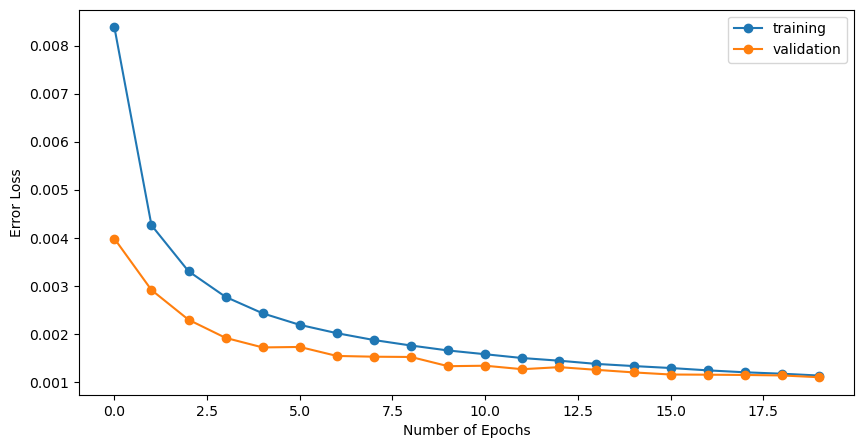

Trianing Recall Macro Curve


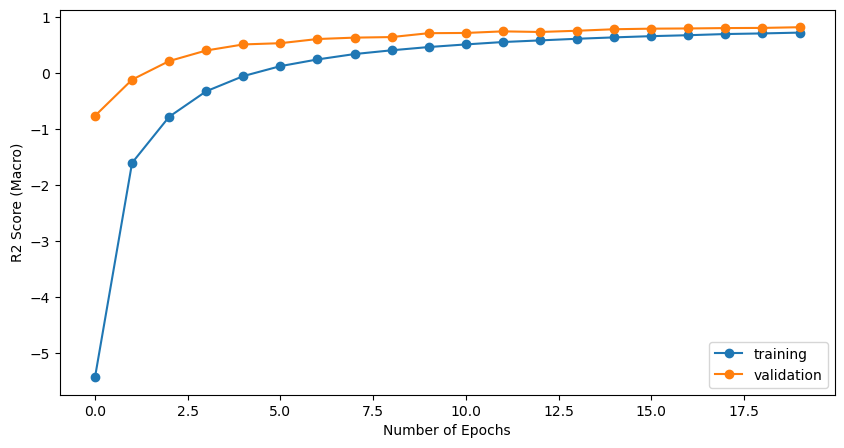

R2 (Uniform Average)
0.8144319597874606
Unseen Class Labels
[ 4  5 12 15 16 20 21 25 26 29 39 40 48]
TSNE spatialisation of Unseen Classes


alt.LayerChart(...)

alt.LayerChart(...)

              precision    recall  f1-score   support

      beaver       0.92      0.14      0.25       152
   dalmatian       0.41      0.72      0.53       442
        mole       0.00      0.00      0.00        75
     leopard       0.43      0.90      0.58       568
       moose       0.28      0.46      0.35       554
     gorilla       0.46      0.12      0.19       709
          ox       0.50      0.97      0.66       588
  chimpanzee       0.91      0.02      0.03       566
     hamster       0.42      0.82      0.56       640
      rabbit       0.00      0.00      0.00       877
 giant+panda       0.03      0.00      0.00       692
        deer       0.42      0.47      0.44      1069
     raccoon       0.31      0.47      0.37       408

    accuracy                           0.41      7340
   macro avg       0.39      0.39      0.30      7340
weighted avg       0.37      0.41      0.32      7340

Top_1_accuracy for UnSeen Validation split 01 per class -  [0.14473684 0.723981

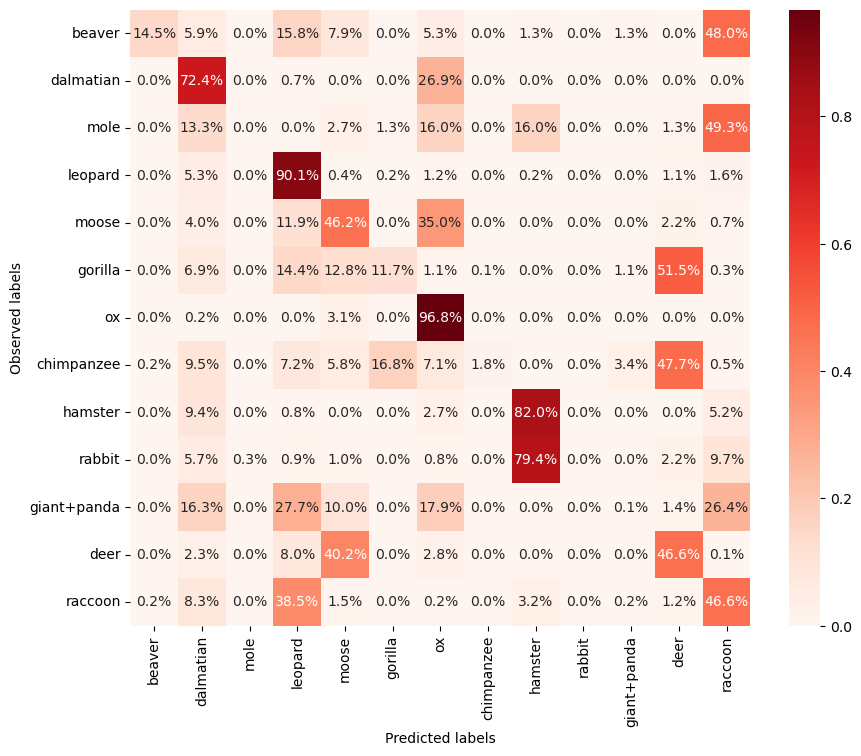

              precision    recall  f1-score   support

ARTIODACTYLA       0.62      0.91      0.74      2211
   CARNIVORA       0.67      0.83      0.74      2110
EULIPOTYPHLA       0.00      0.00      0.00        75
  LAGOMORPHA       0.00      0.00      0.00       877
    PRIMATES       0.99      0.15      0.26      1275
    RODENTIA       0.43      0.69      0.53       792

    accuracy                           0.61      7340
   macro avg       0.45      0.43      0.38      7340
weighted avg       0.60      0.61      0.54      7340

Top_1_accuracy for UnSeen Validation split 01 per class -  [0.90773406 0.82701422 0.         0.         0.14823529 0.69318182]
Top_1_accuracy for UnSeen Validation split 01 -  0.4293608978827887


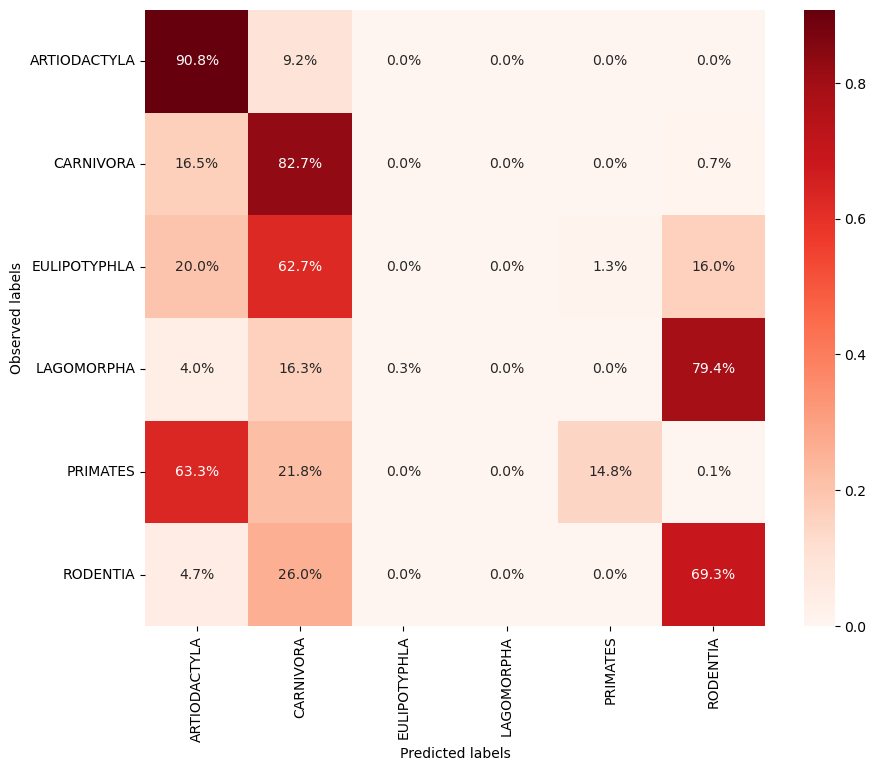

 Top- 2  Accuracy per class 
 Top- 2  Accuracy =  0.5574494941285423 
              0         1
0        beaver  0.263158
1     dalmatian  0.909502
2          mole  0.013333
3       leopard  0.957746
4         moose  0.861011
5       gorilla  0.458392
6            ox  1.000000
7    chimpanzee  0.166078
8       hamster  0.898438
9        rabbit  0.030787
10  giant+panda  0.007225
11         deer  0.830683
12      raccoon  0.850490 

 Top- 3  Accuracy per class 
 Top- 3  Accuracy =  0.6552710887480652 
              0         1
0        beaver  0.407895
1     dalmatian  0.988688
2          mole  0.053333
3       leopard  0.980634
4         moose  0.925993
5       gorilla  0.630465
6            ox  1.000000
7    chimpanzee  0.452297
8       hamster  0.943750
9        rabbit  0.128848
10  giant+panda  0.108382
11         deer  0.944808
12      raccoon  0.953431 

 Top- 4  Accuracy per class 
 Top- 4  Accuracy =  0.7443551097589928 
              0         1
0        beaver  0.467105
1     

In [15]:
Train01 = CZSL(mode = "Train", 
               split = 1, 
               DNN = ProjectionNetwork1, 
               epochs = 20, 
               bs = 8, 
               numunits = 1024, 
               lr = 0.75, 
               optimiser = nn.ReLU(), 
               dropout = 0.2, 
               mom = 0, 
               wd = 0,  
               device = 'cuda', 
               checkpoint = CP1, 
               dist_type = 'cosine')

#mode
#1. "Train" - Use Train Val split
#2. "Test" - For Unseen Test Data

#split
# 1 -Train/Val Split 1
# 2 -Train/Val Split 2
# 3 -Train/Val Split 3

#pred_type
#1. "Probabilistic" - continous real numbers giving probability for prdiction to be 1
#2. "Deterministic" - 1 or 0 prediction values

#dist_type
#1. euclidean
#2. cosine
#3. hamming
#4. jaccard

### 8.2 Train Validation Split 02

Training DNN
  epoch    train_loss    train_r2_score    valid_loss    valid_r2_score    cp     dur
-------  ------------  ----------------  ------------  ----------------  ----  ------
      1        0.0082           -4.2235        0.0037           -0.4896     +  2.8322
      2        0.0040           -1.1652        0.0025            0.1242     +  2.4849
      3        0.0031           -0.4645        0.0020            0.3625     +  2.4681
      4        0.0026           -0.1150        0.0019            0.4865     +  2.6045
      5        0.0023            0.1020        0.0016            0.5803     +  2.7319
      6        0.0020            0.2552        0.0014            0.6365     +  2.5082
      7        0.0019            0.3530        0.0014            0.6705     +  2.6893
      8        0.0017            0.4310        0.0013            0.7092     +  2.3996
      9        0.0016            0.4856        0.0013            0.7295     +  2.4531
     10        0.0015            0.5374  

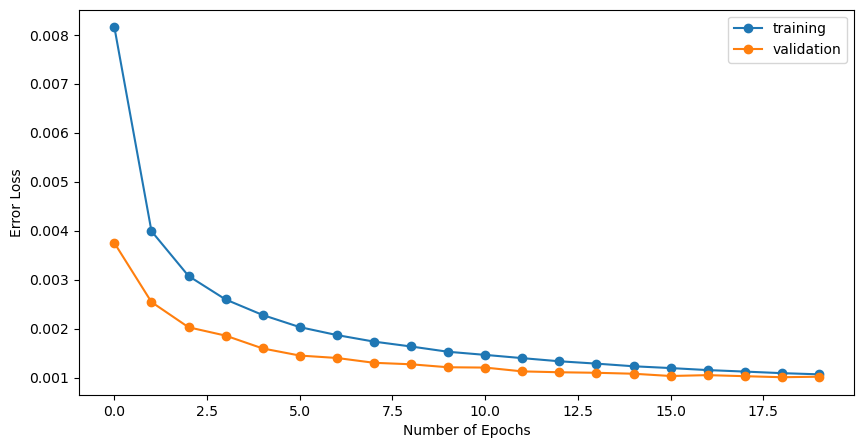

Trianing Recall Macro Curve


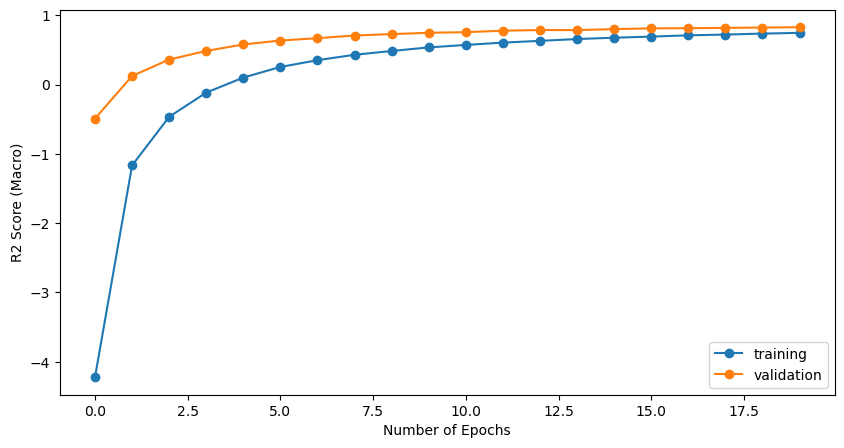

R2 (Uniform Average)
0.8199716170162029
Unseen Class Labels
[ 1  2  3  4  5  6 11 21 22 33 36 38 42]
TSNE spatialisation of Unseen Classes


alt.LayerChart(...)

alt.LayerChart(...)

              precision    recall  f1-score   support

    antelope       0.78      0.43      0.55       864
grizzly+bear       0.83      0.61      0.71       690
killer+whale       0.91      0.69      0.79       231
      beaver       0.00      0.00      0.00       152
   dalmatian       0.29      0.86      0.43       442
 persian+cat       0.60      0.11      0.19       599
       skunk       0.35      0.08      0.13       157
          ox       0.40      0.98      0.57       588
         fox       0.26      0.94      0.40       540
   chihuahua       0.27      0.11      0.16       448
       otter       1.00      0.00      0.01       592
       zebra       0.02      0.01      0.02       942
         pig       0.15      0.02      0.03       558

    accuracy                           0.38      6803
   macro avg       0.45      0.37      0.31      6803
weighted avg       0.47      0.38      0.31      6803

Top_1_accuracy for UnSeen Validation split 01 per class -  [0.43055556 0.613043

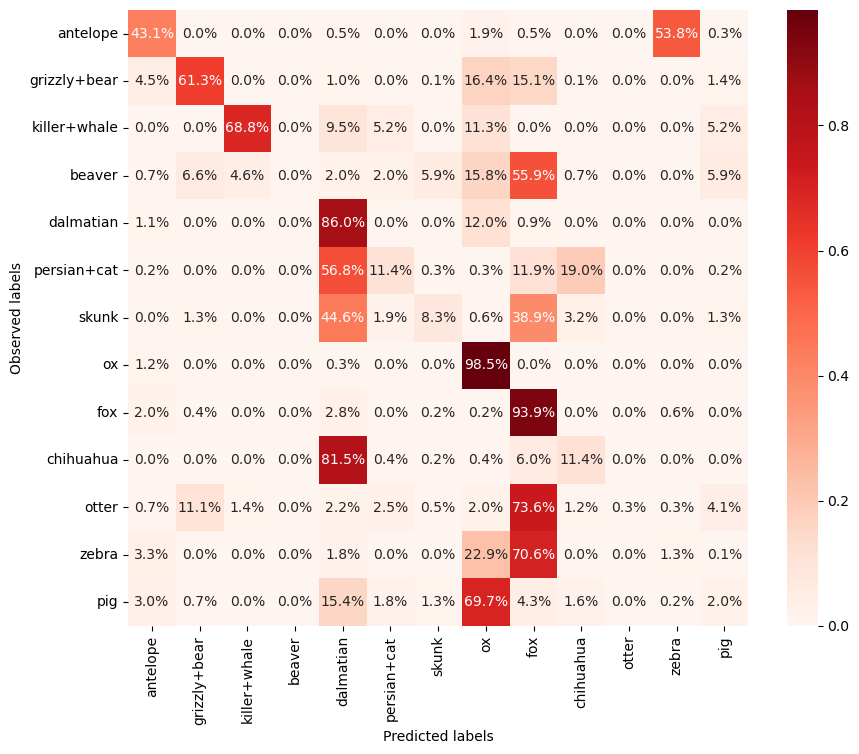

                precision    recall  f1-score   support

  ARTIODACTYLA       0.74      0.71      0.72      2241
     CARNIVORA       0.77      0.92      0.83      3468
PERISSODACTYLA       0.02      0.01      0.02       942
      RODENTIA       0.00      0.00      0.00       152

      accuracy                           0.70      6803
     macro avg       0.38      0.41      0.39      6803
  weighted avg       0.64      0.70      0.67      6803

Top_1_accuracy for UnSeen Validation split 01 per class -  [0.70995091 0.91753172 0.01273885 0.        ]
Top_1_accuracy for UnSeen Validation split 01 -  0.4100553717107894


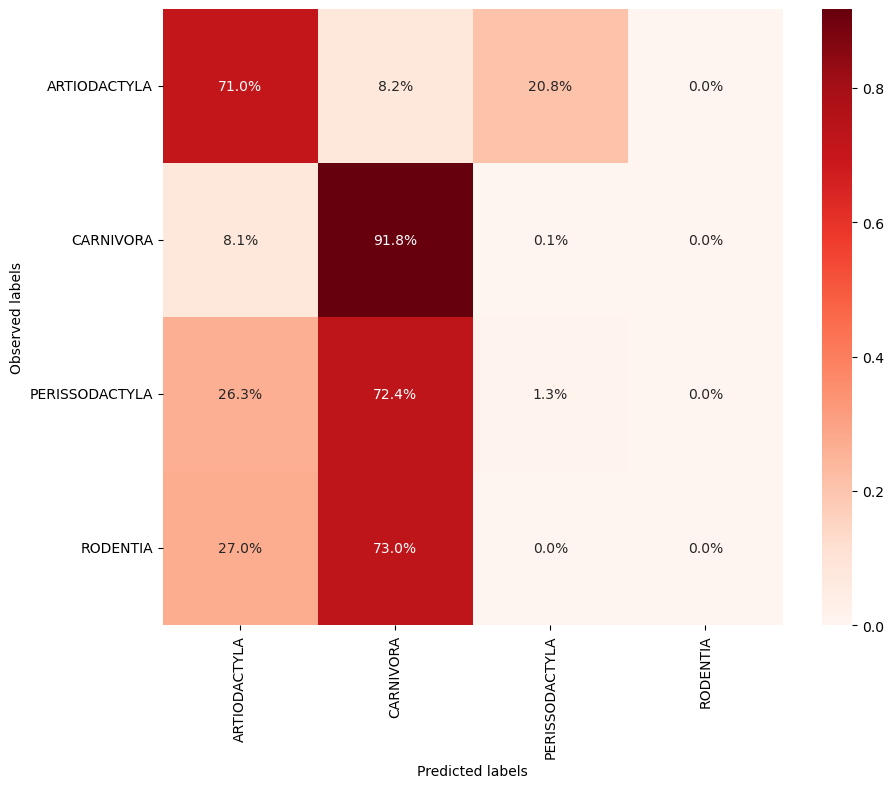

AttributeError: 'DataFrame' object has no attribute 'labels'

In [50]:
Train02 = CZSL(mode = "Train", 
               split = 2, 
               DNN = ProjectionNetwork1, 
               epochs = 20, 
               bs = 8, 
               numunits = 1024, 
               lr = 0.75, 
               optimiser = nn.ReLU(), 
               dropout = 0.2, 
               mom = 0, 
               wd = 0,  
               device = 'cuda', 
               checkpoint = CP2, 
               dist_type = 'cosine')

#mode
#1. "Train" - Use Train Val split
#2. "Test" - For Unseen Test Data

#split
# 1 -Train/Val Split 1
# 2 -Train/Val Split 2
# 3 -Train/Val Split 3

#pred_type
#1. "Probabilistic" - continous real numbers giving probability for prdiction to be 1
#2. "Deterministic" - 1 or 0 prediction values

#dist_type
#1. euclidean
#2. cosine
#3. hamming
#4. jaccard

### 8.3 Train Validation Split 03

In [ ]:
Train03 = CZSL(mode = "Train", 
               split = 3, 
               DNN = ProjectionNetwork1, 
               epochs = 20, 
               bs = 8, 
               numunits = 1024, 
               lr = 0.75, 
               optimiser = nn.ReLU(), 
               dropout = 0.2, 
               mom = 0, 
               wd = 0,  
               device = 'cuda', 
               checkpoint = CP3, 
               dist_type = 'cosine')

#mode
#1. "Train" - Use Train Val split
#2. "Test" - For Unseen Test Data

#split
# 1 -Train/Val Split 1
# 2 -Train/Val Split 2
# 3 -Train/Val Split 3

#pred_type
#1. "Probabilistic" - continous real numbers giving probability for prdiction to be 1
#2. "Deterministic" - 1 or 0 prediction values

#dist_type
#1. euclidean
#2. cosine
#3. hamming
#4. jaccard

# 9. Hyperoptimisation

In [62]:
import argparse
import optuna
from optuna.integration import SkorchPruningCallback

class ProjectionNetwork_hyper(nn.Module):
    def __init__(self, trial: optuna.Trial):
        super(ProjectionNetwork_hyper, self).__init__()        
        layers = []
        n_layers = trial.suggest_int("n_layers", 1, 3)
        dropout = trial.suggest_float("dropout", 0.1, 0.5)
        input_dim = 2048
        for i in range(n_layers):
            output_dim = trial.suggest_int("n_units_l{}".format(i), 4, 2048, log=True)
            layers.append(nn.Linear(input_dim, output_dim))
            layers.append(nn.Dropout(dropout))
            layers.append(nn.ReLU())
            input_dim = output_dim
        
        layers.append(nn.Linear(input_dim, kg_vec))

        self.model = nn.Sequential(*layers)
        print(self.model)  
        
                        
    def forward(self, x):
        out = self.model(x)
        return out   
    

def objective(trial: optuna.Trial):
    learning_rate = trial.suggest_loguniform('lr', .001, 1)
    bs = trial.suggest_int("batch_size", 4, 64)
    ep = trial.suggest_int("max_epoch", 5, 50)
    mom = trial.suggest_loguniform('optimizer__momentum', .90, .99)
   
       
    hyper_net1 = NeuralNetRegressor(
    ProjectionNetwork_hyper(trial),
    batch_size= bs,
    max_epochs=ep,
    lr=learning_rate,
    criterion = nn.MSELoss, # to use with Sigmoid 
    optimizer=torch.optim.SGD,
    optimizer__momentum = mom,
    optimizer__weight_decay = 0,
    train_split = ValidSplit(5),
    callbacks=[valid_r2_score,SkorchPruningCallback(trial, 'valid_r2_score')],
    callbacks__valid_acc=None,
    device='cuda'
    )        
    
    hyper_net2 =  NeuralNetRegressor(
    ProjectionNetwork_hyper(trial),
    batch_size= bs,
    max_epochs=ep,
    lr=learning_rate,
    criterion = nn.MSELoss, # to use with Sigmoid 
    optimizer=torch.optim.SGD,
    optimizer__momentum = mom,
    optimizer__weight_decay = 0,
    train_split = ValidSplit(5),
    callbacks=[valid_r2_score,SkorchPruningCallback(trial, 'valid_r2_score')],
    callbacks__valid_acc=None,
    device='cuda'
    )        
    
    hyper_net3 =  NeuralNetRegressor(
    ProjectionNetwork_hyper(trial),
    batch_size= bs,
    max_epochs=ep,
    lr=learning_rate,
    criterion = nn.MSELoss, # to use with Sigmoid 
    optimizer=torch.optim.SGD,
    optimizer__momentum = mom,
    optimizer__weight_decay = 0,
    train_split = ValidSplit(5),
    callbacks=[valid_r2_score,SkorchPruningCallback(trial, 'valid_r2_score')],
    callbacks__valid_acc=None,
    device='cuda'
    )        
    
    #Split 1
    X1= X_train1.astype(np.float32).values
    y1 = y_train1.astype(np.float32).values
    hyper_net1.fit(X1, y1)
    #predict attributes for Unseen classes 
    y_pred_unseen1 = hyper_net1.predict(ValData01.iloc[:,1:2049].astype(np.float32).values)   
          
    #limit search space to unseen classes 
    predicatedf_CZSL1 = predicate_df[predicate_df['classes'].isin((ValData01.classes.unique()).tolist())]
    animal_attributes1 = np.array(predicatedf_CZSL1.iloc[:,-kg_vec:])
    animal_attributes_labels1 = predicatedf_CZSL1['animal_label'].unique()
            
    #assign classes to unseen data by assigning label from closest class using Cosine Distance           
    dist_CZSL1= (1-distance.cdist(y_pred_unseen1, animal_attributes1, 'cosine'))        
    CZSL_label_prediction1 = np.array([np.argmax(output) for output in dist_CZSL1])
    
    #replace predicted labels with unseen class labels 
    CZSL_label_prediction1 = np.select([CZSL_label_prediction1 == 0, CZSL_label_prediction1 == 1, CZSL_label_prediction1 == 2, CZSL_label_prediction1 == 3
          , CZSL_label_prediction1 == 4, CZSL_label_prediction1 == 5, CZSL_label_prediction1 == 6, CZSL_label_prediction1 == 7
          , CZSL_label_prediction1 == 8, CZSL_label_prediction1 == 9, CZSL_label_prediction1 == 10, CZSL_label_prediction1 == 11
          , CZSL_label_prediction1 == 12], [animal_attributes_labels1[0], animal_attributes_labels1[1], animal_attributes_labels1[2]
          , animal_attributes_labels1[3], animal_attributes_labels1[4], animal_attributes_labels1[5]
          , animal_attributes_labels1[6], animal_attributes_labels1[7], animal_attributes_labels1[8], animal_attributes_labels1[9]
          , animal_attributes_labels1[10], animal_attributes_labels1[11], animal_attributes_labels1[12]], CZSL_label_prediction1)
        
    recall_score1 = recall_score(ValData01['animal_label'], CZSL_label_prediction1, average = 'macro')
    
    #Split 2
    X2= X_train2.astype(np.float32).values
    y2 = y_train2.astype(np.float32).values
    hyper_net2.fit(X2, y2)
    #predict attributes for Unseen classes 
    y_pred_unseen2 = hyper_net2.predict(ValData02.iloc[:,1:2049].astype(np.float32).values)
  
    #limit search space to unseen classes 
    predicatedf_CZSL2 = predicate_df[predicate_df['classes'].isin((ValData02.classes.unique()).tolist())]
    animal_attributes2 = np.array(predicatedf_CZSL2.iloc[:,-kg_vec:])
    animal_attributes_labels2 = predicatedf_CZSL2['animal_label'].unique()
            
    #assign classes to unseen data by assigning label from closest class using Cosing Distance           
    dist_CZSL2= (1-distance.cdist(y_pred_unseen2, animal_attributes2, 'cosine'))        
    CZSL_label_prediction2 = np.array([np.argmax(output) for output in dist_CZSL2])
    
    #replace predicted labels with unseen class labels 
    CZSL_label_prediction2 = np.select([CZSL_label_prediction2 == 0, CZSL_label_prediction2 == 1, CZSL_label_prediction2 == 2, CZSL_label_prediction2 == 3
          , CZSL_label_prediction2 == 4, CZSL_label_prediction2 == 5, CZSL_label_prediction2 == 6, CZSL_label_prediction2 == 7
          , CZSL_label_prediction2 == 8, CZSL_label_prediction2 == 9, CZSL_label_prediction2 == 10, CZSL_label_prediction2 == 11
          , CZSL_label_prediction2 == 12], [animal_attributes_labels2[0], animal_attributes_labels2[1], animal_attributes_labels2[2]
          , animal_attributes_labels2[3], animal_attributes_labels2[4], animal_attributes_labels2[5]
          , animal_attributes_labels2[6], animal_attributes_labels2[7], animal_attributes_labels2[8], animal_attributes_labels2[9]
          , animal_attributes_labels2[10], animal_attributes_labels2[11], animal_attributes_labels2[12]], CZSL_label_prediction2)
        
    recall_score2 = recall_score(ValData02['animal_label'], CZSL_label_prediction2, average = 'macro')
   
    #Split 3
    X3= X_train3.astype(np.float32).values
    y3 = y_train3.astype(np.float32).values
    hyper_net3.fit(X3, y3)
    #predict attributes for Unseen classes 
    y_pred_unseen3 = hyper_net3.predict(ValData03.iloc[:,1:2049].astype(np.float32).values)
         
    #limit search space to unseen classes 
    predicatedf_CZSL3 = predicate_df[predicate_df['classes'].isin((ValData03.classes.unique()).tolist())]
    animal_attributes3 = np.array(predicatedf_CZSL3.iloc[:,-kg_vec:])
    animal_attributes_labels3 = predicatedf_CZSL3['animal_label'].unique()
            
    #assign classes to unseen data by assigning label from closest class using Cosing Distance           
    dist_CZSL3= (1-distance.cdist(y_pred_unseen3, animal_attributes3, 'cosine'))        
    CZSL_label_prediction3 = np.array([np.argmax(output) for output in dist_CZSL3])
    
    #replace predicted labels with unseen class labels 
    CZSL_label_prediction3 = np.select([CZSL_label_prediction3 == 0, CZSL_label_prediction3 == 1, CZSL_label_prediction3 == 2, CZSL_label_prediction3 == 3
          , CZSL_label_prediction3 == 4, CZSL_label_prediction3 == 5, CZSL_label_prediction3 == 6, CZSL_label_prediction3 == 7
          , CZSL_label_prediction3 == 8, CZSL_label_prediction3 == 9, CZSL_label_prediction3 == 10, CZSL_label_prediction3 == 11
          , CZSL_label_prediction3 == 12], [animal_attributes_labels3[0], animal_attributes_labels3[1], animal_attributes_labels3[2]
          , animal_attributes_labels3[3], animal_attributes_labels3[4], animal_attributes_labels3[5]
          , animal_attributes_labels3[6], animal_attributes_labels3[7], animal_attributes_labels3[8], animal_attributes_labels3[9]
          , animal_attributes_labels3[10], animal_attributes_labels3[11], animal_attributes_labels3[12]], CZSL_label_prediction3)
        
    recall_score3 = recall_score(ValData03['animal_label'], CZSL_label_prediction3, average = 'macro')
    
    results = [recall_score1,recall_score2,recall_score3]
    print(results)
    #hyper_net.set_params(verbose=0)

    return np.mean(results)

In [63]:
if __name__ == "__main__":
    parser = argparse.ArgumentParser(description="DNN with KG.")
    parser.add_argument(
        "--pruning",
        "-p",
        action="store_true",
        help="Activate the pruning feature. `MedianPruner` stops unpromising "
        "trials at the early stages of training.",
    )
    args, unknown = parser.parse_known_args()

    pruner = optuna.pruners.MedianPruner() if args.pruning else optuna.pruners.NopPruner()

    study = optuna.create_study(direction="maximize", pruner=pruner)
    study.optimize(objective, n_trials=100, timeout=1000)

    print("Number of finished trials: {}".format(len(study.trials)))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: {}".format(trial.value))

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

[I 2022-12-10 03:04:14,492] A new study created in memory with name: no-name-2ba25d43-a134-4fdd-bf09-a665c5a9c81b


Sequential(
  (0): Linear(in_features=2048, out_features=606, bias=True)
  (1): Dropout(p=0.47890238850760236, inplace=False)
  (2): ReLU()
  (3): Linear(in_features=606, out_features=1020, bias=True)
)
Sequential(
  (0): Linear(in_features=2048, out_features=606, bias=True)
  (1): Dropout(p=0.47890238850760236, inplace=False)
  (2): ReLU()
  (3): Linear(in_features=606, out_features=1020, bias=True)
)
Sequential(
  (0): Linear(in_features=2048, out_features=606, bias=True)
  (1): Dropout(p=0.47890238850760236, inplace=False)
  (2): ReLU()
  (3): Linear(in_features=606, out_features=1020, bias=True)
)
  epoch    train_loss    valid_loss    valid_r2_score     dur
-------  ------------  ------------  ----------------  ------
      1        0.0093        0.0082            0.0779  2.2930
      2        0.0082        0.0078            0.1542  2.2240
      3        0.0082        0.0082            0.0775  2.2125
      4        0.0081        0.0079            0.1288  2.1710
      5        0.00

     33        0.0078        0.0075            0.1174  2.6717
     34        0.0078        0.0075            0.1248  2.5867
     35        0.0078        0.0075            0.1231  2.6428
     36        0.0078        0.0075            0.1172  2.5196
     37        0.0078        0.0075            0.1271  2.5270
     38        0.0078        0.0075            0.1240  2.6039
     39        0.0078        0.0074            0.1241  2.6859


[I 2022-12-10 03:09:17,103] Trial 0 finished with value: 0.12376909704183307 and parameters: {'lr': 0.5218164192494622, 'batch_size': 9, 'max_epoch': 39, 'optimizer__momentum': 0.9397540942994486, 'n_layers': 1, 'dropout': 0.47890238850760236, 'n_units_l0': 606}. Best is trial 0 with value: 0.12376909704183307.


[0.09458785329866891, 0.15007849293563577, 0.12664094489119454]
Sequential(
  (0): Linear(in_features=2048, out_features=131, bias=True)
  (1): Dropout(p=0.1669571601186206, inplace=False)
  (2): ReLU()
  (3): Linear(in_features=131, out_features=1020, bias=True)
)
Sequential(
  (0): Linear(in_features=2048, out_features=131, bias=True)
  (1): Dropout(p=0.1669571601186206, inplace=False)
  (2): ReLU()
  (3): Linear(in_features=131, out_features=1020, bias=True)
)
Sequential(
  (0): Linear(in_features=2048, out_features=131, bias=True)
  (1): Dropout(p=0.1669571601186206, inplace=False)
  (2): ReLU()
  (3): Linear(in_features=131, out_features=1020, bias=True)
)
  epoch    train_loss    valid_loss    valid_r2_score     dur
-------  ------------  ------------  ----------------  ------
      1        0.0389        0.0359          -17.8465  3.1728
      2        0.0346        0.0329          -16.3925  3.1441
      3        0.0316        0.0297          -15.3828  3.0964
      4        0.028

      9        0.0151        0.0126           -5.0886  3.1440
     10        0.0136        0.0112           -3.5987  2.9620
     11        0.0124        0.0102           -2.4966  3.1033
     12        0.0117        0.0097           -1.7666  2.9582
     13        0.0113        0.0093           -1.2871  2.9754
     14        0.0109        0.0090           -0.9788  3.1642
     15        0.0107        0.0089           -0.7698  2.9164
     16        0.0105        0.0088           -0.6669  3.0305
     17        0.0105        0.0087           -0.5797  2.9666
     18        0.0103        0.0086           -0.5274  3.0339
     19        0.0103        0.0086           -0.4945  2.9401
     20        0.0102        0.0086           -0.4872  2.9721
     21        0.0102        0.0085           -0.4403  3.0859
     22        0.0101        0.0085           -0.4411  3.1229
     23        0.0100        0.0085           -0.4229  2.9860
     24        0.0100        0.0085           -0.4179  3.0263
     25 

[I 2022-12-10 03:15:24,123] Trial 1 finished with value: 0.08169555941140554 and parameters: {'lr': 0.0010454818736572973, 'batch_size': 7, 'max_epoch': 37, 'optimizer__momentum': 0.9250226948664462, 'n_layers': 1, 'dropout': 0.1669571601186206, 'n_units_l0': 131}. Best is trial 0 with value: 0.12376909704183307.


[0.07706192724243266, 0.09110167406870703, 0.07692307692307693]
Sequential(
  (0): Linear(in_features=2048, out_features=7, bias=True)
  (1): Dropout(p=0.3059198577962078, inplace=False)
  (2): ReLU()
  (3): Linear(in_features=7, out_features=1020, bias=True)
)
Sequential(
  (0): Linear(in_features=2048, out_features=7, bias=True)
  (1): Dropout(p=0.3059198577962078, inplace=False)
  (2): ReLU()
  (3): Linear(in_features=7, out_features=1020, bias=True)
)
Sequential(
  (0): Linear(in_features=2048, out_features=7, bias=True)
  (1): Dropout(p=0.3059198577962078, inplace=False)
  (2): ReLU()
  (3): Linear(in_features=7, out_features=1020, bias=True)
)
  epoch    train_loss    valid_loss    valid_r2_score     dur
-------  ------------  ------------  ----------------  ------
      1        0.0530        0.0304          -30.4367  0.8467
      2        0.0209        0.0146           -8.3935  0.8496
      3        0.0120        0.0103           -2.3152  0.8369
      4        0.0096        0.0

[I 2022-12-10 03:16:39,966] Trial 2 finished with value: 0.07692307692307693 and parameters: {'lr': 0.06931211565644152, 'batch_size': 27, 'max_epoch': 29, 'optimizer__momentum': 0.9074385613928528, 'n_layers': 1, 'dropout': 0.3059198577962078, 'n_units_l0': 7}. Best is trial 0 with value: 0.12376909704183307.


[0.07692307692307693, 0.07692307692307693, 0.07692307692307693]
Sequential(
  (0): Linear(in_features=2048, out_features=66, bias=True)
  (1): Dropout(p=0.3575219402464672, inplace=False)
  (2): ReLU()
  (3): Linear(in_features=66, out_features=48, bias=True)
  (4): Dropout(p=0.3575219402464672, inplace=False)
  (5): ReLU()
  (6): Linear(in_features=48, out_features=244, bias=True)
  (7): Dropout(p=0.3575219402464672, inplace=False)
  (8): ReLU()
  (9): Linear(in_features=244, out_features=1020, bias=True)
)
Sequential(
  (0): Linear(in_features=2048, out_features=66, bias=True)
  (1): Dropout(p=0.3575219402464672, inplace=False)
  (2): ReLU()
  (3): Linear(in_features=66, out_features=48, bias=True)
  (4): Dropout(p=0.3575219402464672, inplace=False)
  (5): ReLU()
  (6): Linear(in_features=48, out_features=244, bias=True)
  (7): Dropout(p=0.3575219402464672, inplace=False)
  (8): ReLU()
  (9): Linear(in_features=244, out_features=1020, bias=True)
)
Sequential(
  (0): Linear(in_feature

[I 2022-12-10 03:17:19,621] Trial 3 finished with value: 0.0769868773189269 and parameters: {'lr': 0.0011786259708516584, 'batch_size': 30, 'max_epoch': 12, 'optimizer__momentum': 0.9256080722150996, 'n_layers': 3, 'dropout': 0.3575219402464672, 'n_units_l0': 66, 'n_units_l1': 48, 'n_units_l2': 244}. Best is trial 0 with value: 0.12376909704183307.


[0.07600861789222346, 0.07682832501837027, 0.07812368904618694]
Sequential(
  (0): Linear(in_features=2048, out_features=21, bias=True)
  (1): Dropout(p=0.24755163392271304, inplace=False)
  (2): ReLU()
  (3): Linear(in_features=21, out_features=184, bias=True)
  (4): Dropout(p=0.24755163392271304, inplace=False)
  (5): ReLU()
  (6): Linear(in_features=184, out_features=1020, bias=True)
)
Sequential(
  (0): Linear(in_features=2048, out_features=21, bias=True)
  (1): Dropout(p=0.24755163392271304, inplace=False)
  (2): ReLU()
  (3): Linear(in_features=21, out_features=184, bias=True)
  (4): Dropout(p=0.24755163392271304, inplace=False)
  (5): ReLU()
  (6): Linear(in_features=184, out_features=1020, bias=True)
)
Sequential(
  (0): Linear(in_features=2048, out_features=21, bias=True)
  (1): Dropout(p=0.24755163392271304, inplace=False)
  (2): ReLU()
  (3): Linear(in_features=21, out_features=184, bias=True)
  (4): Dropout(p=0.24755163392271304, inplace=False)
  (5): ReLU()
  (6): Linear(i

      2        0.0087        0.0084           -0.0182  0.6465
      3        0.0085        0.0084           -0.0125  0.6275
      4        0.0084        0.0084           -0.0109  0.6524
      5        0.0084        0.0084           -0.0078  0.6673
      6        0.0084        0.0084           -0.0064  0.6570
      7        0.0083        0.0084           -0.0062  0.6554
      8        0.0083        0.0084           -0.0058  0.6319
      9        0.0083        0.0084           -0.0054  0.6089
     10        0.0083        0.0084           -0.0048  0.6655
     11        0.0083        0.0084           -0.0042  0.6623
     12        0.0083        0.0084           -0.0040  0.6410
     13        0.0083        0.0083           -0.0037  0.6421
     14        0.0083        0.0083           -0.0037  0.6481
     15        0.0083        0.0084           -0.0037  0.6217
     16        0.0083        0.0083           -0.0028  0.6292
     17        0.0083        0.0083           -0.0032  0.6595
     18 

[I 2022-12-10 03:18:51,518] Trial 4 finished with value: 0.07692307692307693 and parameters: {'lr': 0.6412572035844463, 'batch_size': 47, 'max_epoch': 43, 'optimizer__momentum': 0.9153738939521806, 'n_layers': 2, 'dropout': 0.24755163392271304, 'n_units_l0': 21, 'n_units_l1': 184}. Best is trial 0 with value: 0.12376909704183307.


[0.07692307692307693, 0.07692307692307693, 0.07692307692307693]
Sequential(
  (0): Linear(in_features=2048, out_features=128, bias=True)
  (1): Dropout(p=0.34081802876590905, inplace=False)
  (2): ReLU()
  (3): Linear(in_features=128, out_features=183, bias=True)
  (4): Dropout(p=0.34081802876590905, inplace=False)
  (5): ReLU()
  (6): Linear(in_features=183, out_features=1020, bias=True)
)
Sequential(
  (0): Linear(in_features=2048, out_features=128, bias=True)
  (1): Dropout(p=0.34081802876590905, inplace=False)
  (2): ReLU()
  (3): Linear(in_features=128, out_features=183, bias=True)
  (4): Dropout(p=0.34081802876590905, inplace=False)
  (5): ReLU()
  (6): Linear(in_features=183, out_features=1020, bias=True)
)
Sequential(
  (0): Linear(in_features=2048, out_features=128, bias=True)
  (1): Dropout(p=0.34081802876590905, inplace=False)
  (2): ReLU()
  (3): Linear(in_features=128, out_features=183, bias=True)
  (4): Dropout(p=0.34081802876590905, inplace=False)
  (5): ReLU()
  (6): Li

[I 2022-12-10 03:19:26,036] Trial 5 finished with value: 0.11507012140344618 and parameters: {'lr': 0.5127503482942359, 'batch_size': 59, 'max_epoch': 19, 'optimizer__momentum': 0.9639160580359162, 'n_layers': 2, 'dropout': 0.34081802876590905, 'n_units_l0': 128, 'n_units_l1': 183}. Best is trial 0 with value: 0.12376909704183307.


[0.10148324811735301, 0.1668040391699086, 0.07692307692307693]
Sequential(
  (0): Linear(in_features=2048, out_features=21, bias=True)
  (1): Dropout(p=0.4305864914739378, inplace=False)
  (2): ReLU()
  (3): Linear(in_features=21, out_features=9, bias=True)
  (4): Dropout(p=0.4305864914739378, inplace=False)
  (5): ReLU()
  (6): Linear(in_features=9, out_features=1020, bias=True)
)
Sequential(
  (0): Linear(in_features=2048, out_features=21, bias=True)
  (1): Dropout(p=0.4305864914739378, inplace=False)
  (2): ReLU()
  (3): Linear(in_features=21, out_features=9, bias=True)
  (4): Dropout(p=0.4305864914739378, inplace=False)
  (5): ReLU()
  (6): Linear(in_features=9, out_features=1020, bias=True)
)
Sequential(
  (0): Linear(in_features=2048, out_features=21, bias=True)
  (1): Dropout(p=0.4305864914739378, inplace=False)
  (2): ReLU()
  (3): Linear(in_features=21, out_features=9, bias=True)
  (4): Dropout(p=0.4305864914739378, inplace=False)
  (5): ReLU()
  (6): Linear(in_features=9, out

[I 2022-12-10 03:20:37,796] Trial 6 finished with value: 0.07692307692307693 and parameters: {'lr': 0.09303534705952998, 'batch_size': 37, 'max_epoch': 30, 'optimizer__momentum': 0.9203477445551453, 'n_layers': 2, 'dropout': 0.4305864914739378, 'n_units_l0': 21, 'n_units_l1': 9}. Best is trial 0 with value: 0.12376909704183307.


[0.07692307692307693, 0.07692307692307693, 0.07692307692307693]
Sequential(
  (0): Linear(in_features=2048, out_features=1566, bias=True)
  (1): Dropout(p=0.24253141726212044, inplace=False)
  (2): ReLU()
  (3): Linear(in_features=1566, out_features=170, bias=True)
  (4): Dropout(p=0.24253141726212044, inplace=False)
  (5): ReLU()
  (6): Linear(in_features=170, out_features=15, bias=True)
  (7): Dropout(p=0.24253141726212044, inplace=False)
  (8): ReLU()
  (9): Linear(in_features=15, out_features=1020, bias=True)
)
Sequential(
  (0): Linear(in_features=2048, out_features=1566, bias=True)
  (1): Dropout(p=0.24253141726212044, inplace=False)
  (2): ReLU()
  (3): Linear(in_features=1566, out_features=170, bias=True)
  (4): Dropout(p=0.24253141726212044, inplace=False)
  (5): ReLU()
  (6): Linear(in_features=170, out_features=15, bias=True)
  (7): Dropout(p=0.24253141726212044, inplace=False)
  (8): ReLU()
  (9): Linear(in_features=15, out_features=1020, bias=True)
)
Sequential(
  (0): Lin

[I 2022-12-10 03:22:47,170] Trial 7 finished with value: 0.07692307692307693 and parameters: {'lr': 0.009248002970813336, 'batch_size': 21, 'max_epoch': 22, 'optimizer__momentum': 0.96133055900267, 'n_layers': 3, 'dropout': 0.24253141726212044, 'n_units_l0': 1566, 'n_units_l1': 170, 'n_units_l2': 15}. Best is trial 0 with value: 0.12376909704183307.


[0.07692307692307693, 0.07692307692307693, 0.07692307692307693]
Number of finished trials: 8
Best trial:
  Value: 0.12376909704183307
  Params: 
    lr: 0.5218164192494622
    batch_size: 9
    max_epoch: 39
    optimizer__momentum: 0.9397540942994486
    n_layers: 1
    dropout: 0.47890238850760236
    n_units_l0: 606


# 10. CZSL on Unseen Test Set using Hyperoptimsation parameters

Training DNN
  epoch    train_loss    train_r2_score    valid_loss    valid_r2_score    cp     dur
-------  ------------  ----------------  ------------  ----------------  ----  ------
      1        0.0093           -0.8476        0.0080            0.1077     +  1.9444
      2        0.0082            0.0805        0.0083            0.0591        1.6791
      3        0.0082            0.0897        0.0079            0.1335     +  1.7702
      4        0.0082            0.0905        0.0080            0.1061        1.7099
      5        0.0081            0.0883        0.0080            0.1237        1.7909
      6        0.0081            0.0810        0.0081            0.1128        1.9447
      7        0.0081            0.0860        0.0079            0.1272        2.1069
      8        0.0081            0.0917        0.0079            0.1333     +  1.8903
      9        0.0082            0.0899        0.0081            0.1011        1.9211
     10        0.0081            0.0910  

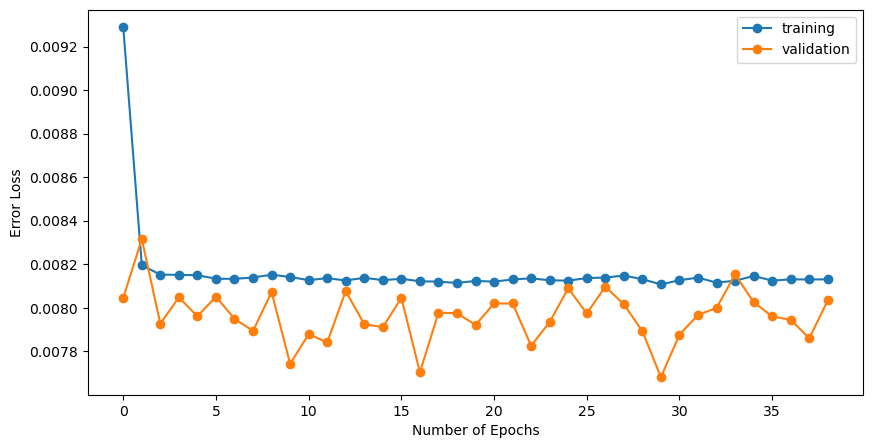

Trianing Recall Macro Curve


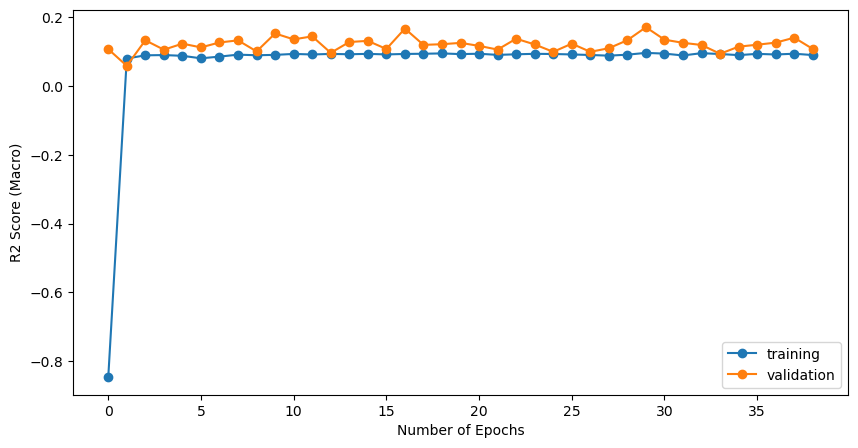

R2 (Uniform Average)
0.17319127842288323
Unseen Class Labels
[ 4  5 12 15 16 20 21 25 26 29 39 40 48]
TSNE spatialisation of Unseen Classes


alt.LayerChart(...)

alt.LayerChart(...)

              precision    recall  f1-score   support

      beaver       0.00      0.00      0.00       152
   dalmatian       0.06      0.46      0.11       442
        mole       0.00      0.00      0.00        75
     leopard       0.00      0.00      0.00       568
       moose       0.10      0.72      0.17       554
     gorilla       0.00      0.00      0.00       709
          ox       0.00      0.00      0.00       588
  chimpanzee       0.00      0.00      0.00       566
     hamster       0.00      0.00      0.00       640
      rabbit       0.00      0.00      0.00       877
 giant+panda       0.00      0.00      0.00       692
        deer       0.00      0.00      0.00      1069
     raccoon       0.00      0.00      0.00       408

    accuracy                           0.08      7340
   macro avg       0.01      0.09      0.02      7340
weighted avg       0.01      0.08      0.02      7340

Top_1_accuracy for UnSeen Validation split 01 per class -  [0.         0.457013

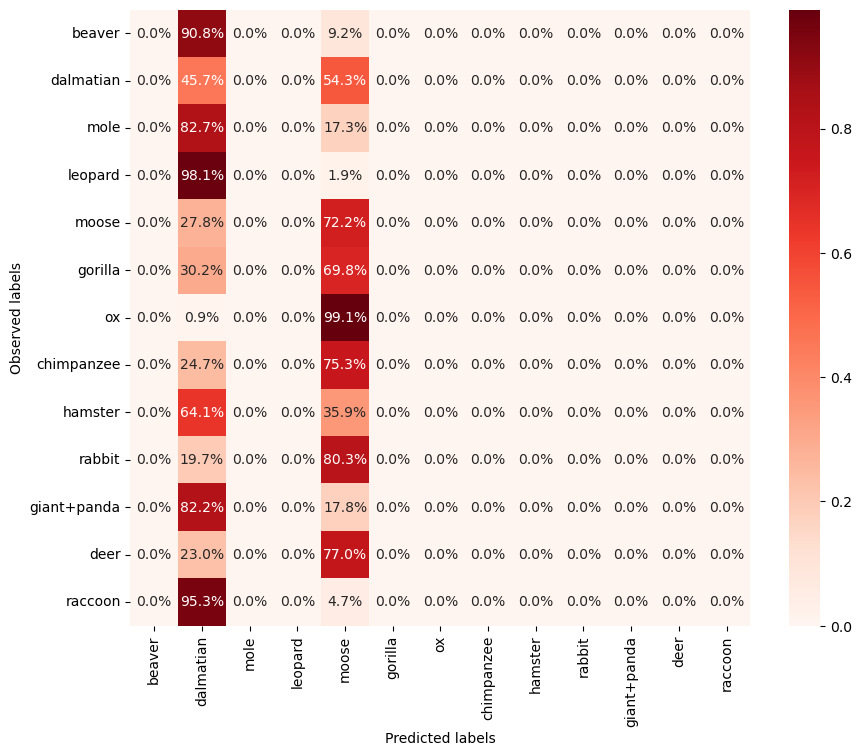

              precision    recall  f1-score   support

ARTIODACTYLA       0.44      0.82      0.57      2211
   CARNIVORA       0.53      0.81      0.64      2110
EULIPOTYPHLA       0.00      0.00      0.00        75
  LAGOMORPHA       0.00      0.00      0.00       877
    PRIMATES       0.00      0.00      0.00      1275
    RODENTIA       0.00      0.00      0.00       792

    accuracy                           0.48      7340
   macro avg       0.16      0.27      0.20      7340
weighted avg       0.28      0.48      0.36      7340

Top_1_accuracy for UnSeen Validation split 01 per class -  [0.81682497 0.81374408 0.         0.         0.         0.        ]
Top_1_accuracy for UnSeen Validation split 01 -  0.2717615069846802


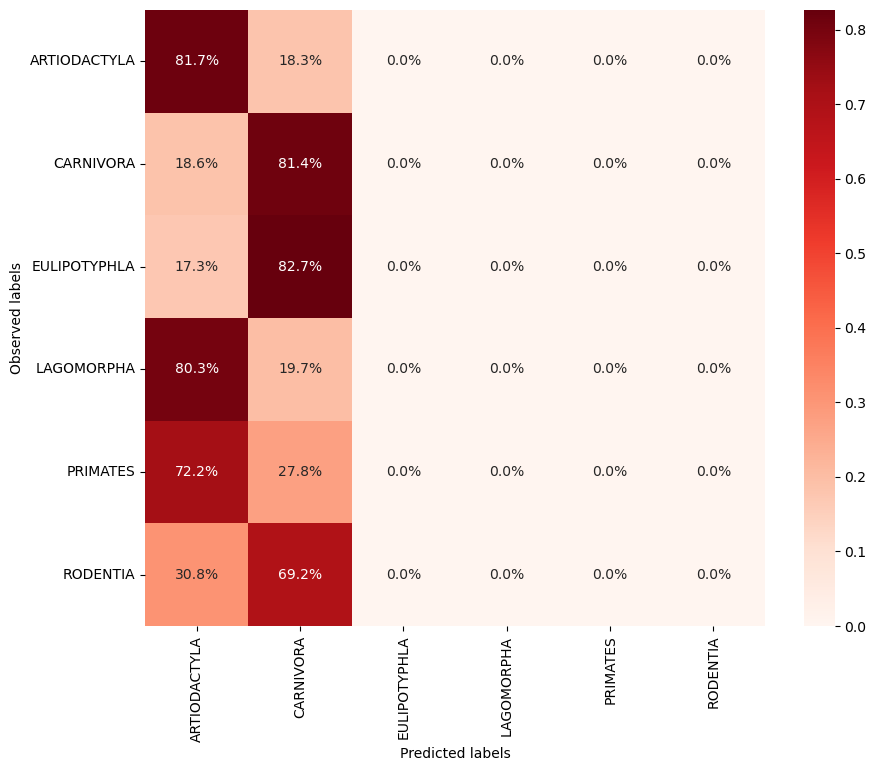

 Top- 2  Accuracy per class 
 Top- 2  Accuracy =  0.2323101681486706 
              0         1
0        beaver  0.000000
1     dalmatian  0.484163
2          mole  0.000000
3       leopard  0.748239
4         moose  0.797834
5       gorilla  0.000000
6            ox  0.989796
7    chimpanzee  0.000000
8       hamster  0.000000
9        rabbit  0.000000
10  giant+panda  0.000000
11         deer  0.000000
12      raccoon  0.000000 

 Top- 3  Accuracy per class 
 Top- 3  Accuracy =  0.29315839688582623 
              0         1
0        beaver  0.000000
1     dalmatian  1.000000
2          mole  0.000000
3       leopard  0.771127
4         moose  0.861011
5       gorilla  0.000000
6            ox  1.000000
7    chimpanzee  0.000000
8       hamster  0.000000
9        rabbit  0.000000
10  giant+panda  0.000000
11         deer  0.000000
12      raccoon  0.178922 

 Top- 4  Accuracy per class 
 Top- 4  Accuracy =  0.38065231542051586 
              0         1
0        beaver  0.000000
1   

In [31]:
Train01 = CZSL(mode = "Train", 
               split = 1, 
               DNN = ProjectionNetwork1, 
               epochs = 39, 
               bs = 9, 
               numunits = 606, 
               lr = 0.5218164192494622, 
               optimiser = nn.ReLU(), 
               dropout = 0.47890238850760236, 
               mom = 0.9397540942994486, 
               wd = 0,  
               device = 'cuda', 
               checkpoint = CP1, 
               dist_type = 'cosine')

#mode
#1. "Train" - Use Train Val split
#2. "Test" - For Unseen Test Data

#split
# 1 -Train/Val Split 1
# 2 -Train/Val Split 2
# 3 -Train/Val Split 3

#pred_type
#1. "Probabilistic" - continous real numbers giving probability for prdiction to be 1
#2. "Deterministic" - 1 or 0 prediction values

#dist_type
#1. euclidean
#2. cosine
#3. hamming
#4. jaccard

Training DNN
  epoch    train_loss    train_r2_score    valid_loss    valid_r2_score    cp     dur
-------  ------------  ----------------  ------------  ----------------  ----  ------
      1        0.0094           -0.6866        0.0086           -0.0016     +  2.0447
      2        0.0085           -0.0029        0.0086           -0.0014        1.7041
      3        0.0085           -0.0014        0.0086           -0.0013        1.8620
      4        0.0085           -0.0012        0.0086           -0.0013        1.8914
      5        0.0085           -0.0019        0.0086           -0.0013        1.8951
      6        0.0085           -0.0014        0.0086           -0.0013        1.9271
      7        0.0085           -0.0012        0.0086           -0.0013        1.8277
      8        0.0085           -0.0012        0.0086           -0.0013        1.9093
      9        0.0085           -0.0012        0.0086           -0.0013        1.9047
     10        0.0085           -0.0012  

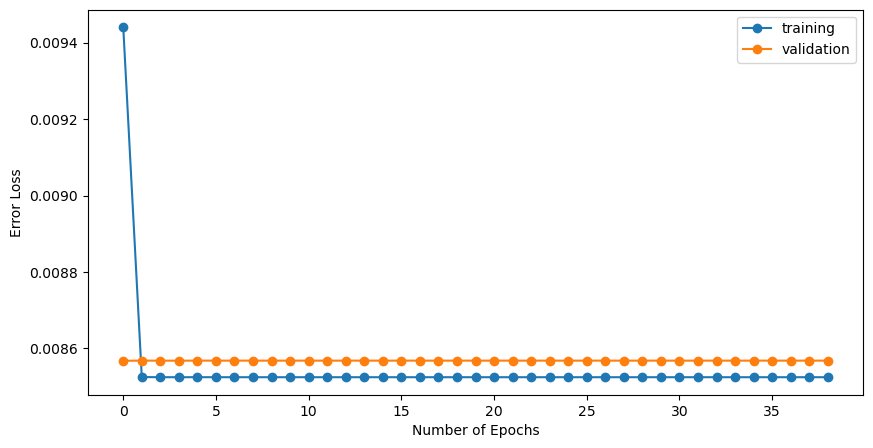

Trianing Recall Macro Curve


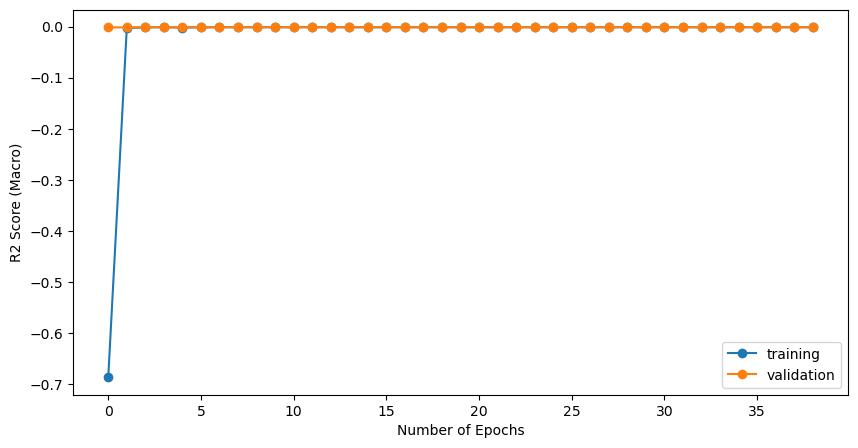

R2 (Uniform Average)
-0.0007839339597247163
Unseen Class Labels
[ 1  2  3  4  5  6 11 21 22 33 36 38 42]
TSNE spatialisation of Unseen Classes


alt.LayerChart(...)

alt.LayerChart(...)

              precision    recall  f1-score   support

    antelope       0.00      0.00      0.00       864
grizzly+bear       0.00      0.00      0.00       690
killer+whale       0.00      0.00      0.00       231
      beaver       0.00      0.00      0.00       152
   dalmatian       0.00      0.00      0.00       442
 persian+cat       0.00      0.00      0.00       599
       skunk       0.00      0.00      0.00       157
          ox       0.00      0.00      0.00       588
         fox       0.08      1.00      0.15       540
   chihuahua       0.00      0.00      0.00       448
       otter       0.00      0.00      0.00       592
       zebra       0.00      0.00      0.00       942
         pig       0.00      0.00      0.00       558

    accuracy                           0.08      6803
   macro avg       0.01      0.08      0.01      6803
weighted avg       0.01      0.08      0.01      6803

Top_1_accuracy for UnSeen Validation split 01 per class -  [0. 0. 0. 0. 0. 0. 0

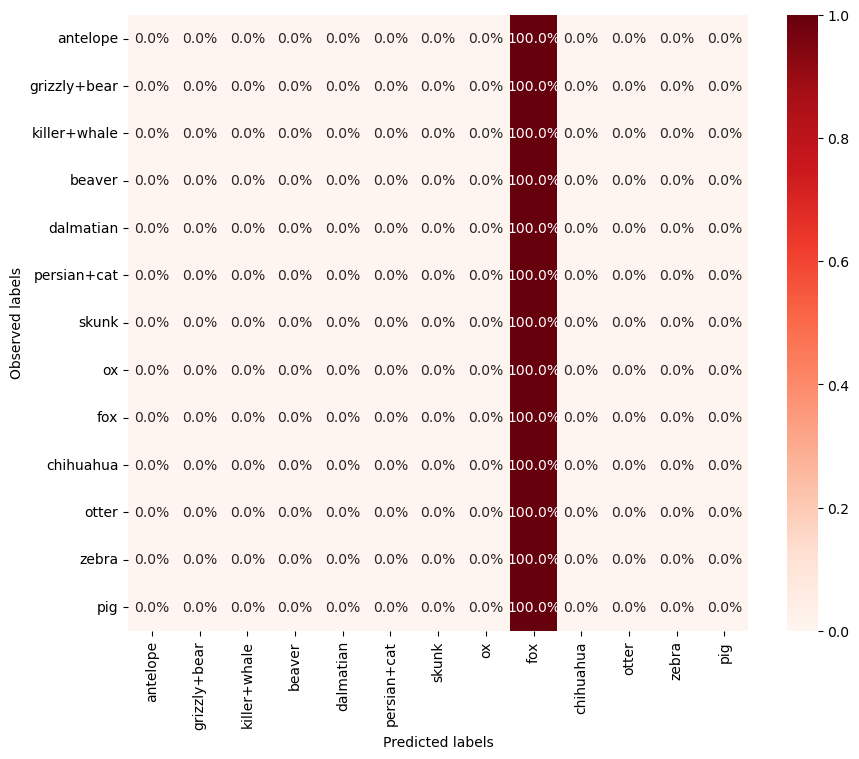

                precision    recall  f1-score   support

  ARTIODACTYLA       0.00      0.00      0.00      2241
     CARNIVORA       0.51      1.00      0.68      3468
PERISSODACTYLA       0.00      0.00      0.00       942
      RODENTIA       0.00      0.00      0.00       152

      accuracy                           0.51      6803
     macro avg       0.13      0.25      0.17      6803
  weighted avg       0.26      0.51      0.34      6803

Top_1_accuracy for UnSeen Validation split 01 per class -  [0. 1. 0. 0.]
Top_1_accuracy for UnSeen Validation split 01 -  0.25


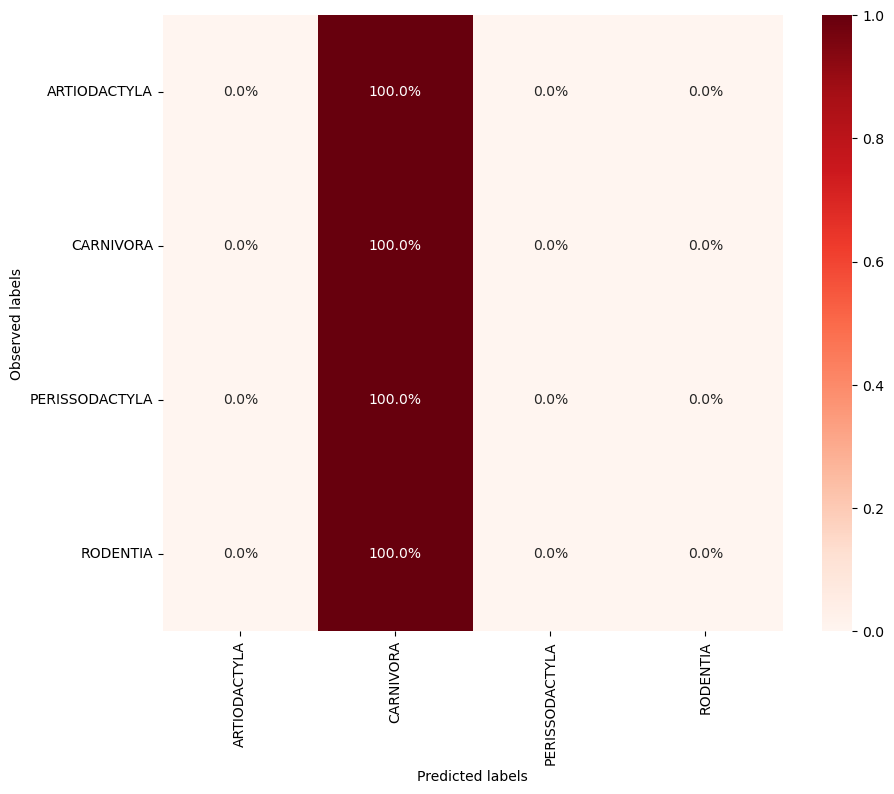

 Top- 2  Accuracy per class 
 Top- 2  Accuracy =  0.15384615384615385 
               0    1
0       antelope  0.0
1   grizzly+bear  0.0
2   killer+whale  0.0
3         beaver  0.0
4      dalmatian  0.0
5    persian+cat  0.0
6          skunk  0.0
7             ox  1.0
8            fox  1.0
9      chihuahua  0.0
10         otter  0.0
11         zebra  0.0
12           pig  0.0 

 Top- 3  Accuracy per class 
 Top- 3  Accuracy =  0.23076923076923078 
               0    1
0       antelope  0.0
1   grizzly+bear  0.0
2   killer+whale  0.0
3         beaver  0.0
4      dalmatian  1.0
5    persian+cat  0.0
6          skunk  0.0
7             ox  1.0
8            fox  1.0
9      chihuahua  0.0
10         otter  0.0
11         zebra  0.0
12           pig  0.0 

 Top- 4  Accuracy per class 
 Top- 4  Accuracy =  0.3076923076923077 
               0    1
0       antelope  1.0
1   grizzly+bear  0.0
2   killer+whale  0.0
3         beaver  0.0
4      dalmatian  1.0
5    persian+cat  0.0
6          sku

In [32]:
Train02 = CZSL(mode = "Train", 
               split = 2, 
               DNN = ProjectionNetwork1, 
               epochs = 39, 
               bs = 9, 
               numunits = 606, 
               lr = 0.5218164192494622, 
               optimiser = nn.ReLU(), 
               dropout = 0.47890238850760236, 
               mom = 0.9397540942994486, 
               wd = 0,  
               device = 'cuda', 
               checkpoint = CP2, 
               dist_type = 'cosine')

#mode
#1. "Train" - Use Train Val split
#2. "Test" - For Unseen Test Data

#split
# 1 -Train/Val Split 1
# 2 -Train/Val Split 2
# 3 -Train/Val Split 3

#pred_type
#1. "Probabilistic" - continous real numbers giving probability for prdiction to be 1
#2. "Deterministic" - 1 or 0 prediction values

#dist_type
#1. euclidean
#2. cosine
#3. hamming
#4. jaccard

Training DNN
  epoch    train_loss    train_r2_score    valid_loss    valid_r2_score    cp     dur
-------  ------------  ----------------  ------------  ----------------  ----  ------
      1        0.0093           -0.8776        0.0084           -0.0015     +  1.8393
      2        0.0083           -0.0021        0.0084           -0.0014        1.6458
      3        0.0083           -0.0013        0.0084           -0.0014        1.6831
      4        0.0083           -0.0012        0.0084           -0.0014        1.7668
      5        0.0083           -0.0011        0.0084           -0.0014        1.6389
      6        0.0083           -0.0010        0.0084           -0.0014        1.6294
      7        0.0083           -0.0010        0.0084           -0.0014        1.6611
      8        0.0083           -0.0010        0.0084           -0.0014        1.7175
      9        0.0083           -0.0011        0.0084           -0.0014        1.7340
     10        0.0083           -0.0010  

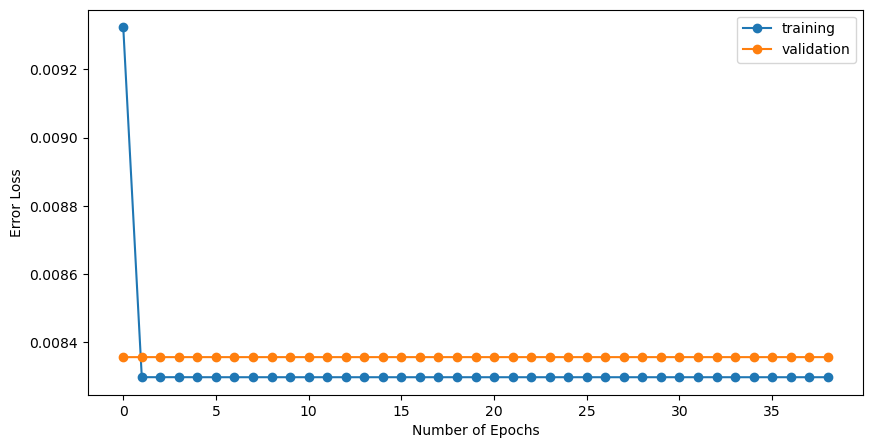

Trianing Recall Macro Curve


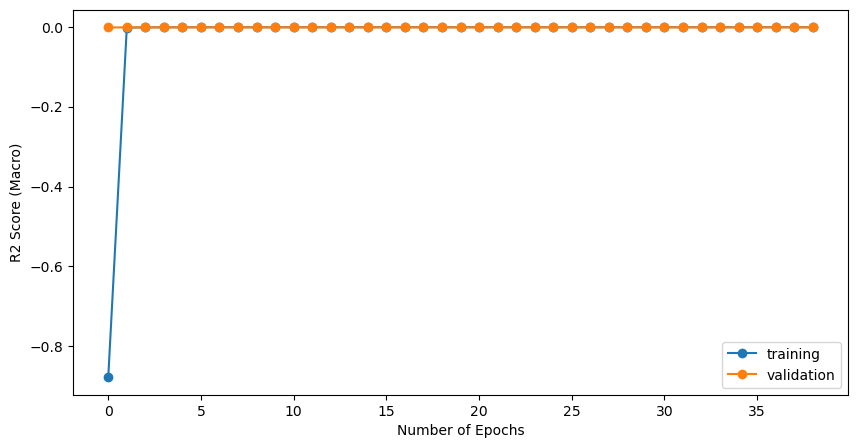

R2 (Uniform Average)
-0.0011915658670715347
Unseen Class Labels
[10 16 18 25 27 28 29 32 33 35 39 42 48]
TSNE spatialisation of Unseen Classes


alt.LayerChart(...)

alt.LayerChart(...)

                precision    recall  f1-score   support

   siamese+cat       0.00      0.00      0.00       400
         moose       0.00      0.00      0.00       554
humpback+whale       0.00      0.00      0.00       565
    chimpanzee       0.00      0.00      0.00       566
      squirrel       0.00      0.00      0.00       961
    rhinoceros       0.00      0.00      0.00       561
        rabbit       0.00      0.00      0.00       877
          wolf       0.06      1.00      0.12       470
     chihuahua       0.00      0.00      0.00       448
        weasel       0.00      0.00      0.00       222
   giant+panda       0.00      0.00      0.00       692
           pig       0.00      0.00      0.00       558
       raccoon       0.00      0.00      0.00       408

      accuracy                           0.06      7282
     macro avg       0.00      0.08      0.01      7282
  weighted avg       0.00      0.06      0.01      7282

Top_1_accuracy for UnSeen Validation split 01

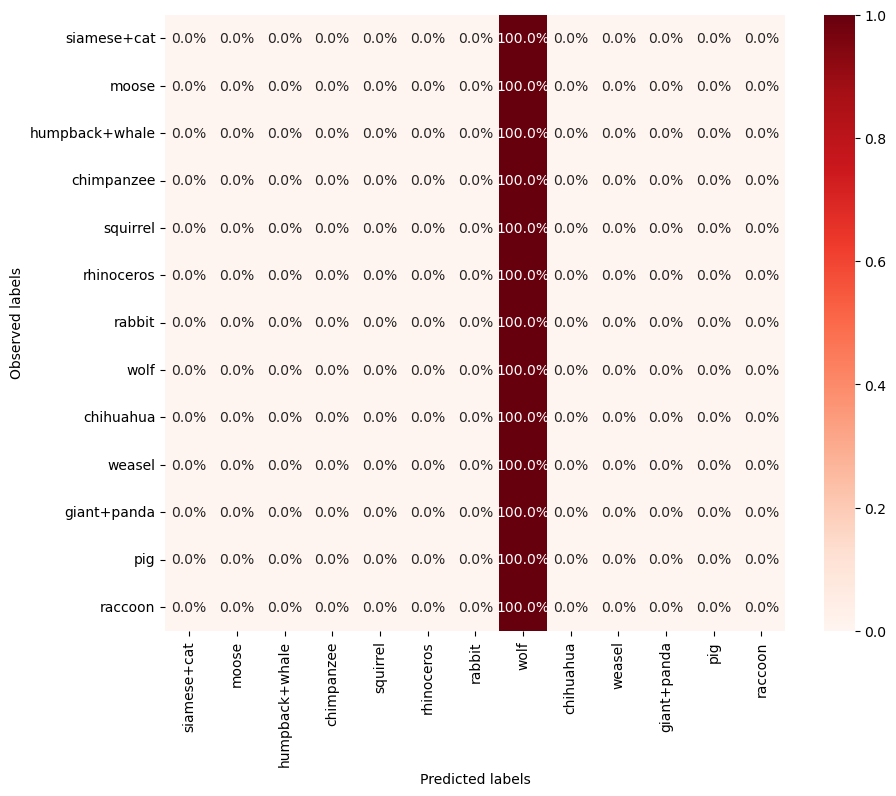

                precision    recall  f1-score   support

  ARTIODACTYLA       0.00      0.00      0.00      1677
     CARNIVORA       0.36      1.00      0.53      2640
    LAGOMORPHA       0.00      0.00      0.00       877
PERISSODACTYLA       0.00      0.00      0.00       561
      PRIMATES       0.00      0.00      0.00       566
      RODENTIA       0.00      0.00      0.00       961

      accuracy                           0.36      7282
     macro avg       0.06      0.17      0.09      7282
  weighted avg       0.13      0.36      0.19      7282

Top_1_accuracy for UnSeen Validation split 01 per class -  [0. 1. 0. 0. 0. 0.]
Top_1_accuracy for UnSeen Validation split 01 -  0.16666666666666666


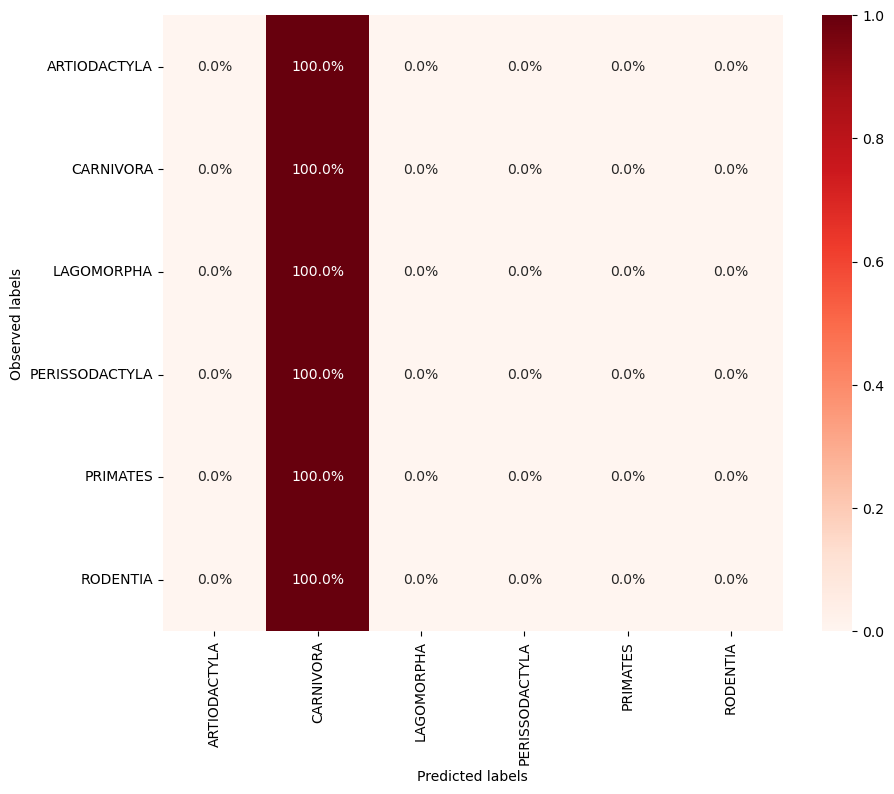

 Top- 2  Accuracy per class 
 Top- 2  Accuracy =  0.15384615384615385 
                 0    1
0      siamese+cat  0.0
1            moose  1.0
2   humpback+whale  0.0
3       chimpanzee  0.0
4         squirrel  0.0
5       rhinoceros  0.0
6           rabbit  0.0
7             wolf  1.0
8        chihuahua  0.0
9           weasel  0.0
10     giant+panda  0.0
11             pig  0.0
12         raccoon  0.0 

 Top- 3  Accuracy per class 
 Top- 3  Accuracy =  0.23076923076923078 
                 0    1
0      siamese+cat  0.0
1            moose  1.0
2   humpback+whale  0.0
3       chimpanzee  0.0
4         squirrel  0.0
5       rhinoceros  0.0
6           rabbit  0.0
7             wolf  1.0
8        chihuahua  0.0
9           weasel  1.0
10     giant+panda  0.0
11             pig  0.0
12         raccoon  0.0 

 Top- 4  Accuracy per class 
 Top- 4  Accuracy =  0.3076923076923077 
                 0    1
0      siamese+cat  1.0
1            moose  1.0
2   humpback+whale  0.0
3       chimpanz

In [33]:
Train03 = CZSL(mode = "Train", 
               split = 3, 
               DNN = ProjectionNetwork1, 
               epochs = 39, 
               bs = 9, 
               numunits = 606, 
               lr = 0.5218164192494622, 
               optimiser = nn.ReLU(), 
               dropout = 0.47890238850760236, 
               mom = 0.9397540942994486, 
               wd = 0,  
               device = 'cuda', 
               checkpoint = CP3, 
               dist_type = 'cosine')

#mode
#1. "Train" - Use Train Val split
#2. "Test" - For Unseen Test Data

#split
# 1 -Train/Val Split 1
# 2 -Train/Val Split 2
# 3 -Train/Val Split 3

#pred_type
#1. "Probabilistic" - continous real numbers giving probability for prdiction to be 1
#2. "Deterministic" - 1 or 0 prediction values

#dist_type
#1. euclidean
#2. cosine
#3. hamming
#4. jaccard

Training DNN
  epoch    train_loss    train_r2_score    valid_loss    valid_r2_score    cp     dur
-------  ------------  ----------------  ------------  ----------------  ----  ------
      1        0.0086           -0.3766        0.0075            0.1602     +  3.5889
      2        0.0079            0.1089        0.0074            0.1694     +  3.5900
      3        0.0079            0.1107        0.0072            0.2070     +  3.4748
      4        0.0078            0.1171        0.0074            0.1886        3.6207
      5        0.0078            0.1138        0.0073            0.1900        3.4710
      6        0.0078            0.1162        0.0075            0.1694        3.6020
      7        0.0078            0.1150        0.0075            0.1592        3.5201
      8        0.0078            0.1135        0.0075            0.1727        3.5045
      9        0.0078            0.1125        0.0074            0.1873        3.5398
     10        0.0078            0.1131  

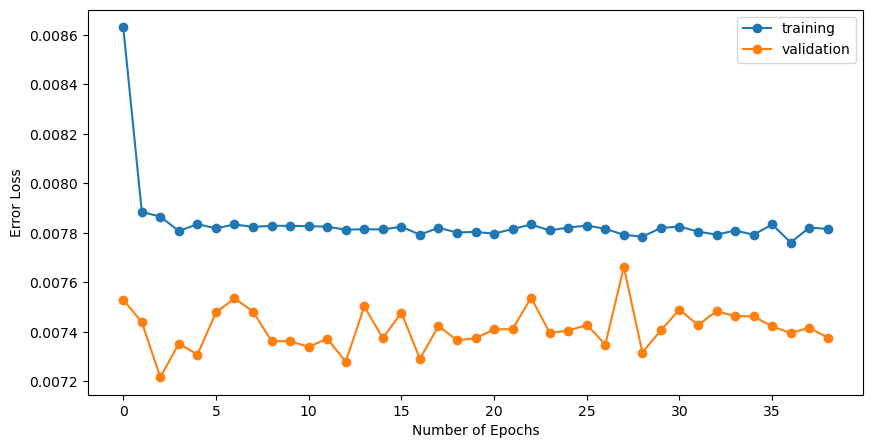

Trianing Recall Macro Curve


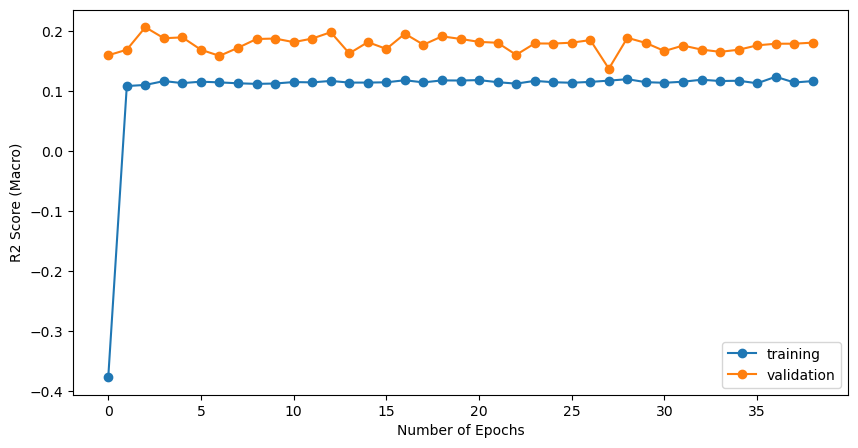

RuntimeError: Error(s) in loading state_dict for ProjectionNetwork1:
	size mismatch for fc1.weight: copying a param with shape torch.Size([369, 2048]) from checkpoint, the shape in current model is torch.Size([606, 2048]).
	size mismatch for fc1.bias: copying a param with shape torch.Size([369]) from checkpoint, the shape in current model is torch.Size([606]).
	size mismatch for fc2.weight: copying a param with shape torch.Size([85, 369]) from checkpoint, the shape in current model is torch.Size([1020, 606]).
	size mismatch for fc2.bias: copying a param with shape torch.Size([85]) from checkpoint, the shape in current model is torch.Size([1020]).

In [34]:
Test01 = CZSL(mode = "Test", 
               split = 1, 
               DNN = ProjectionNetwork1, 
               epochs = 39, 
               bs = 9, 
               numunits = 606, 
               lr = 0.5218164192494622, 
               optimiser = nn.ReLU(), 
               dropout = 0.47890238850760236, 
               mom = 0.9397540942994486, 
               wd = 0,  
               device = 'cuda', 
               checkpoint = CP_final, 
               dist_type = 'cosine')

#mode
#1. "Train" - Use Train Val split
#2. "Test" - For Unseen Test Data

#split
# 1 -Train/Val Split 1
# 2 -Train/Val Split 2
# 3 -Train/Val Split 3

#pred_type
#1. "Probabilistic" - continous real numbers giving probability for prdiction to be 1
#2. "Deterministic" - 1 or 0 prediction values

#dist_type
#1. euclidean
#2. cosine
#3. hamming
#4. jaccard

 # 11. CZSL on Unseen Test Set using non optimised parameters

Training DNN
  epoch    train_loss    train_r2_score    valid_loss    valid_r2_score    cp     dur
-------  ------------  ----------------  ------------  ----------------  ----  ------
      1        0.0074           -3.3243        0.0036           -0.2231     +  5.7832
      2        0.0040           -0.6449        0.0026            0.2616     +  4.0315
      3        0.0031           -0.0866        0.0024            0.3578     +  3.9672
      4        0.0027            0.1794        0.0020            0.5427     +  3.9799
      5        0.0024            0.3281        0.0017            0.6253     +  4.1254
      6        0.0022            0.4269        0.0016            0.6592     +  4.6093
      7        0.0020            0.4907        0.0015            0.7024     +  4.1782
      8        0.0019            0.5435        0.0015            0.7304     +  4.7646
      9        0.0018            0.5828        0.0014            0.7351     +  4.6224
     10        0.0017            0.6171  

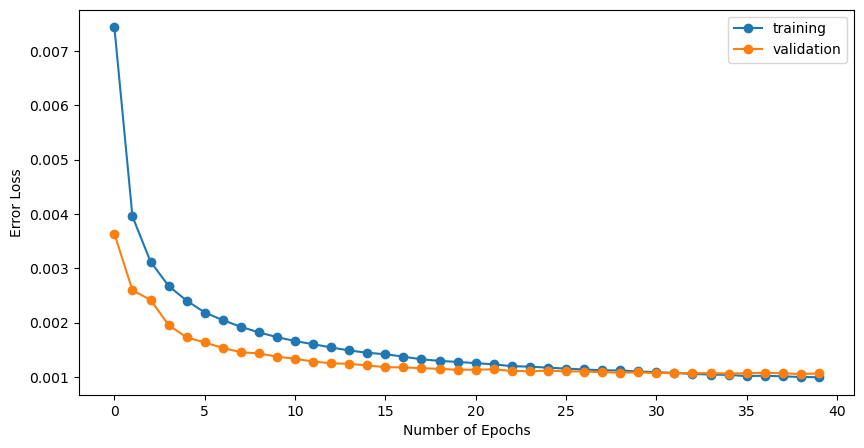

Trianing Recall Macro Curve


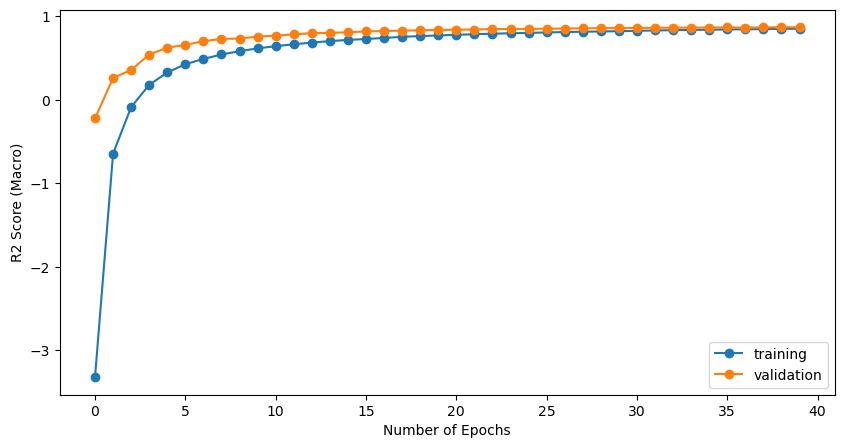

Unseen Class Labels
[ 7  9 23 24 30 31 34 41 47 50]
TSNE spatialisation of Unseen Classes


alt.LayerChart(...)

alt.LayerChart(...)

              precision    recall  f1-score   support

       horse       0.23      0.42      0.29      1645
  blue+whale       0.12      1.00      0.22       174
       sheep       0.39      0.24      0.30      1420
        seal       0.58      0.08      0.15       988
         bat       0.00      0.00      0.00       383
     giraffe       0.03      0.01      0.02      1202
         rat       0.39      0.89      0.54       310
      bobcat       0.66      0.85      0.74       630
      walrus       0.16      0.03      0.05       215
     dolphin       0.62      0.15      0.24       946

    accuracy                           0.29      7913
   macro avg       0.32      0.37      0.25      7913
weighted avg       0.34      0.29      0.25      7913

Top_1_accuracy for UnSeen Validation split 01 per class -  [0.4231003  1.         0.24295775 0.08299595 0.         0.01497504
 0.89032258 0.85079365 0.02790698 0.15010571]
Top_1_accuracy for UnSeen Validation split 01 -  0.3683157959872824


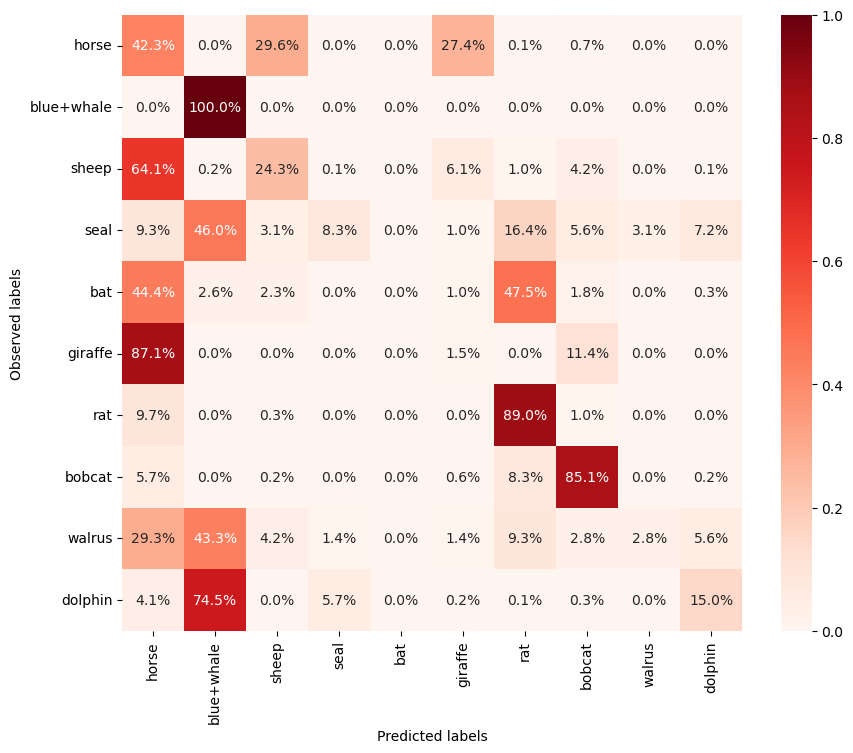

                precision    recall  f1-score   support

  ARTIODACTYLA       0.47      0.39      0.43      3742
     CARNIVORA       0.72      0.39      0.51      1833
    CHIROPTERA       0.00      0.00      0.00       383
PERISSODACTYLA       0.23      0.42      0.29      1645
      RODENTIA       0.39      0.89      0.54       310

      accuracy                           0.40      7913
     macro avg       0.36      0.42      0.35      7913
  weighted avg       0.45      0.40      0.40      7913

Top_1_accuracy for UnSeen Validation split 01 per class -  [0.39444148 0.39225314 0.         0.4231003  0.89032258]
Top_1_accuracy for UnSeen Validation split 01 -  0.4200234993354995


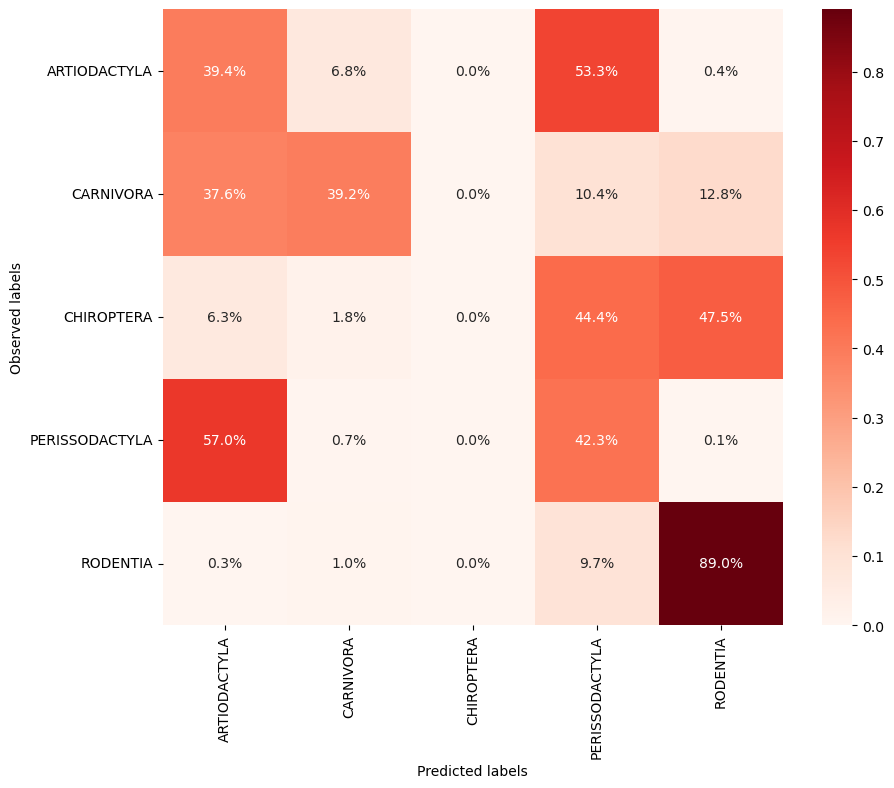

 Top- 2  Accuracy per class 
 Top- 2  Accuracy =  0.5789474740818383 
            0         1
0       horse  0.670517
1  blue+whale  1.000000
2       sheep  0.472535
3        seal  0.200405
4         bat  0.010444
5     giraffe  0.726290
6         rat  0.983871
7      bobcat  0.941270
8      walrus  0.079070
9     dolphin  0.705074 

 Top- 3  Accuracy per class 
 Top- 3  Accuracy =  0.7491388799304635 
            0         1
0       horse  0.998784
1  blue+whale  1.000000
2       sheep  0.912676
3        seal  0.359312
4         bat  0.031332
5     giraffe  0.994176
6         rat  0.993548
7      bobcat  0.976190
8      walrus  0.246512
9     dolphin  0.978858 

 Top- 4  Accuracy per class 
 Top- 4  Accuracy =  0.818340051307095 
            0         1
0       horse  1.000000
1  blue+whale  1.000000
2       sheep  0.963380
3        seal  0.584008
4         bat  0.140992
5     giraffe  1.000000
6         rat  1.000000
7      bobcat  0.988889
8      walrus  0.520930
9     dolphin  0.98

In [15]:
Test02 = CZSL(mode = "Test", 
               split = 3, 
               DNN = ProjectionNetwork1, 
               epochs = 40, 
               bs = 8, 
               numunits = 1024, 
               lr = 0.75, 
               optimiser = nn.ReLU(), 
               dropout = 0.2, 
               mom = 0, 
               wd = 0,  
               device = 'cuda', 
               checkpoint = CP_final, 
               dist_type = 'euclidean')

#mode
#1. "Train" - Use Train Val split
#2. "Test" - For Unseen Test Data

#split
# 1 -Train/Val Split 1
# 2 -Train/Val Split 2
# 3 -Train/Val Split 3

#pred_type
#1. "Probabilistic" - continous real numbers giving probability for prdiction to be 1
#2. "Deterministic" - 1 or 0 prediction values

#dist_type
#1. euclidean
#2. cosine
#3. hamming
#4. jaccard